# Housekeeping

In [28]:
import importlib
import random as rd
import cv2
import sklearn.preprocessing as skp
from sklearn.metrics import make_scorer,fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# From own modules
import file_extraction
import image_preprocessing
import feature_engineering
import feature_encoding_selection as fes
import showcase_and_graphs
import classifier_v2 as classifier

## Save and Load DataFrame & Enconding

### Load DICOM data, features and process to train/test split

In [14]:
# All-in-one import, encoding, splitting:
# Time-intensive, but only needs to be done once.
importlib.reload(fes)

df_cmmd, features_df, data_split, labels_df, classification_labels = fes.prepare_data_classifier()


Category mapping for column 'image_laterality':
{0: 'L', 1: 'R'}

Category mapping for column 'patient_orientation':
{0: "'A', 'FR'", 1: "'A', 'R'", 2: "'P', 'FL'", 3: "'P', 'L'"}

Category mapping for column 'code_meaning':
{0: 'cranio-caudal', 1: 'medio-lateral oblique'}

Category mapping for column 'classification':
{0: 'Benign', 1: 'Malignant'}

Category mapping for column 'subtype':
{0: 'HER2-enriched', 1: 'Luminal A', 2: 'Luminal B', 3: 'missing', 4: 'triple negative'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID1                  5590 non-null   string  
 1   pixel_array          5590 non-null   object  
 2   image_laterality     5590 non-null   category
 3   patient_orientation  5590 non-null   category
 4   code_meaning         5590 non-null   category
 5   Age                  5590 non-null   Int32   
 6  

In [45]:
df_cmmd.head()

ID1                                        pixel_array  \
0  D1-0001  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   
1  D1-0001  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   
2  D1-0002  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   
3  D1-0002  [[176, 147, 161, 163, 173, 189, 187, 175, 202,...   
4  D1-0003  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...   

  image_laterality patient_orientation           code_meaning  Age  number  \
0                R            'P', 'L'          cranio-caudal   44       2   
1                R           'P', 'FL'  medio-lateral oblique   44       2   
2                L            'A', 'R'          cranio-caudal   40       2   
3                L           'A', 'FR'  medio-lateral oblique   40       2   
4                L            'A', 'R'          cranio-caudal   39       2   

     abnormality classification  subtype            indv_bbox  
0  calcification         Benign  missing  (251, 94, 121, 327)  
1  calcification         Benign  missing   (228, 0, 144, 532)  
2  calcification         Benign  missing   (0, 113, 129, 361)  
3  calcification         Benign  missing     (0, 0, 145, 468)  
4  calcification         Benign  missing    (0, 48, 175, 468)

In [ ]:
#  Store df_cmmd, features_df, data_split, labels_df, classification_labels together in a dict
data_dict = {
    'df_cmmd': df_cmmd,
    'features_df': features_df,
    'data_split': data_split,
    'labels_df': labels_df,
    'classification_labels': classification_labels
}

# and save the dict to a file
import pickle
with open('data_dict_final.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [29]:
# load the data_dict from the file
import pickle
with open('data_dict_final.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Unpack the data_dict
df_cmmd = data_dict['df_cmmd']
features_df = data_dict['features_df']
data_split = data_dict['data_split']
labels_df = data_dict['labels_df']
classification_labels = data_dict['classification_labels']

### Load data separately

In [3]:
# Load Data separately through the file_extraction module
# Currently not working, too much memory required
importlib.reload(file_extraction)
df_cmmd_save, labels_df_save = file_extraction.extract_cmmd_dicom(dorl='D')


Category mapping for column 'image_laterality':
{0: 'L', 1: 'R'}

Category mapping for column 'patient_orientation':
{0: "'A', 'FR'", 1: "'A', 'R'", 2: "'P', 'FL'", 3: "'P', 'L'"}

Category mapping for column 'code_meaning':
{0: 'cranio-caudal', 1: 'medio-lateral oblique'}

Category mapping for column 'classification':
{0: 'Benign', 1: 'Malignant'}

Category mapping for column 'subtype':
{0: 'HER2-enriched', 1: 'Luminal A', 2: 'Luminal B', 3: 'missing', 4: 'triple negative'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID1                  5590 non-null   string  
 1   pixel_array          5590 non-null   object  
 2   image_laterality     5590 non-null   category
 3   patient_orientation  5590 non-null   category
 4   code_meaning         5590 non-null   category
 5   Age                  5590 non-null   Int32   
 6  

In [ ]:
# # Pickle the DataFrame df_Cmmd to save memory and load it later
# df_cmmd.to_pickle('df_cmmd.pkl') # takes around 5 min w/ compr an 1 min w/o but ~2Gbs

In [4]:
# To load the DataFrame later, use:
# df_cmmd = pd.read_pickle('df_cmmd.pkl')

# Preprocessing

## Image dimension reduction

In [ ]:
# Execute if not used the AOI function!
# Crop all images to the largest common ROI found in the dataset
importlib.reload(image_preprocessing)
img_dim_crop = {}
df_cmmd_save['pixel_array'], img_dim_crop['width'], img_dim_crop['height'] = image_preprocessing.crop_images_bbox(df_cmmd_save['pixel_array'].tolist(),
                                                                                                         df_cmmd_save['image_laterality'].tolist())

# Store largest ROI for each img in separate column of the dataframe
df_cmmd_save['indv_bbox'] = image_preprocessing.find_common_bbox(df_cmmd_save['pixel_array'],df_cmmd_save['image_laterality'])

Common bounding box dimensions: w: 372, h: 574


## Showcase

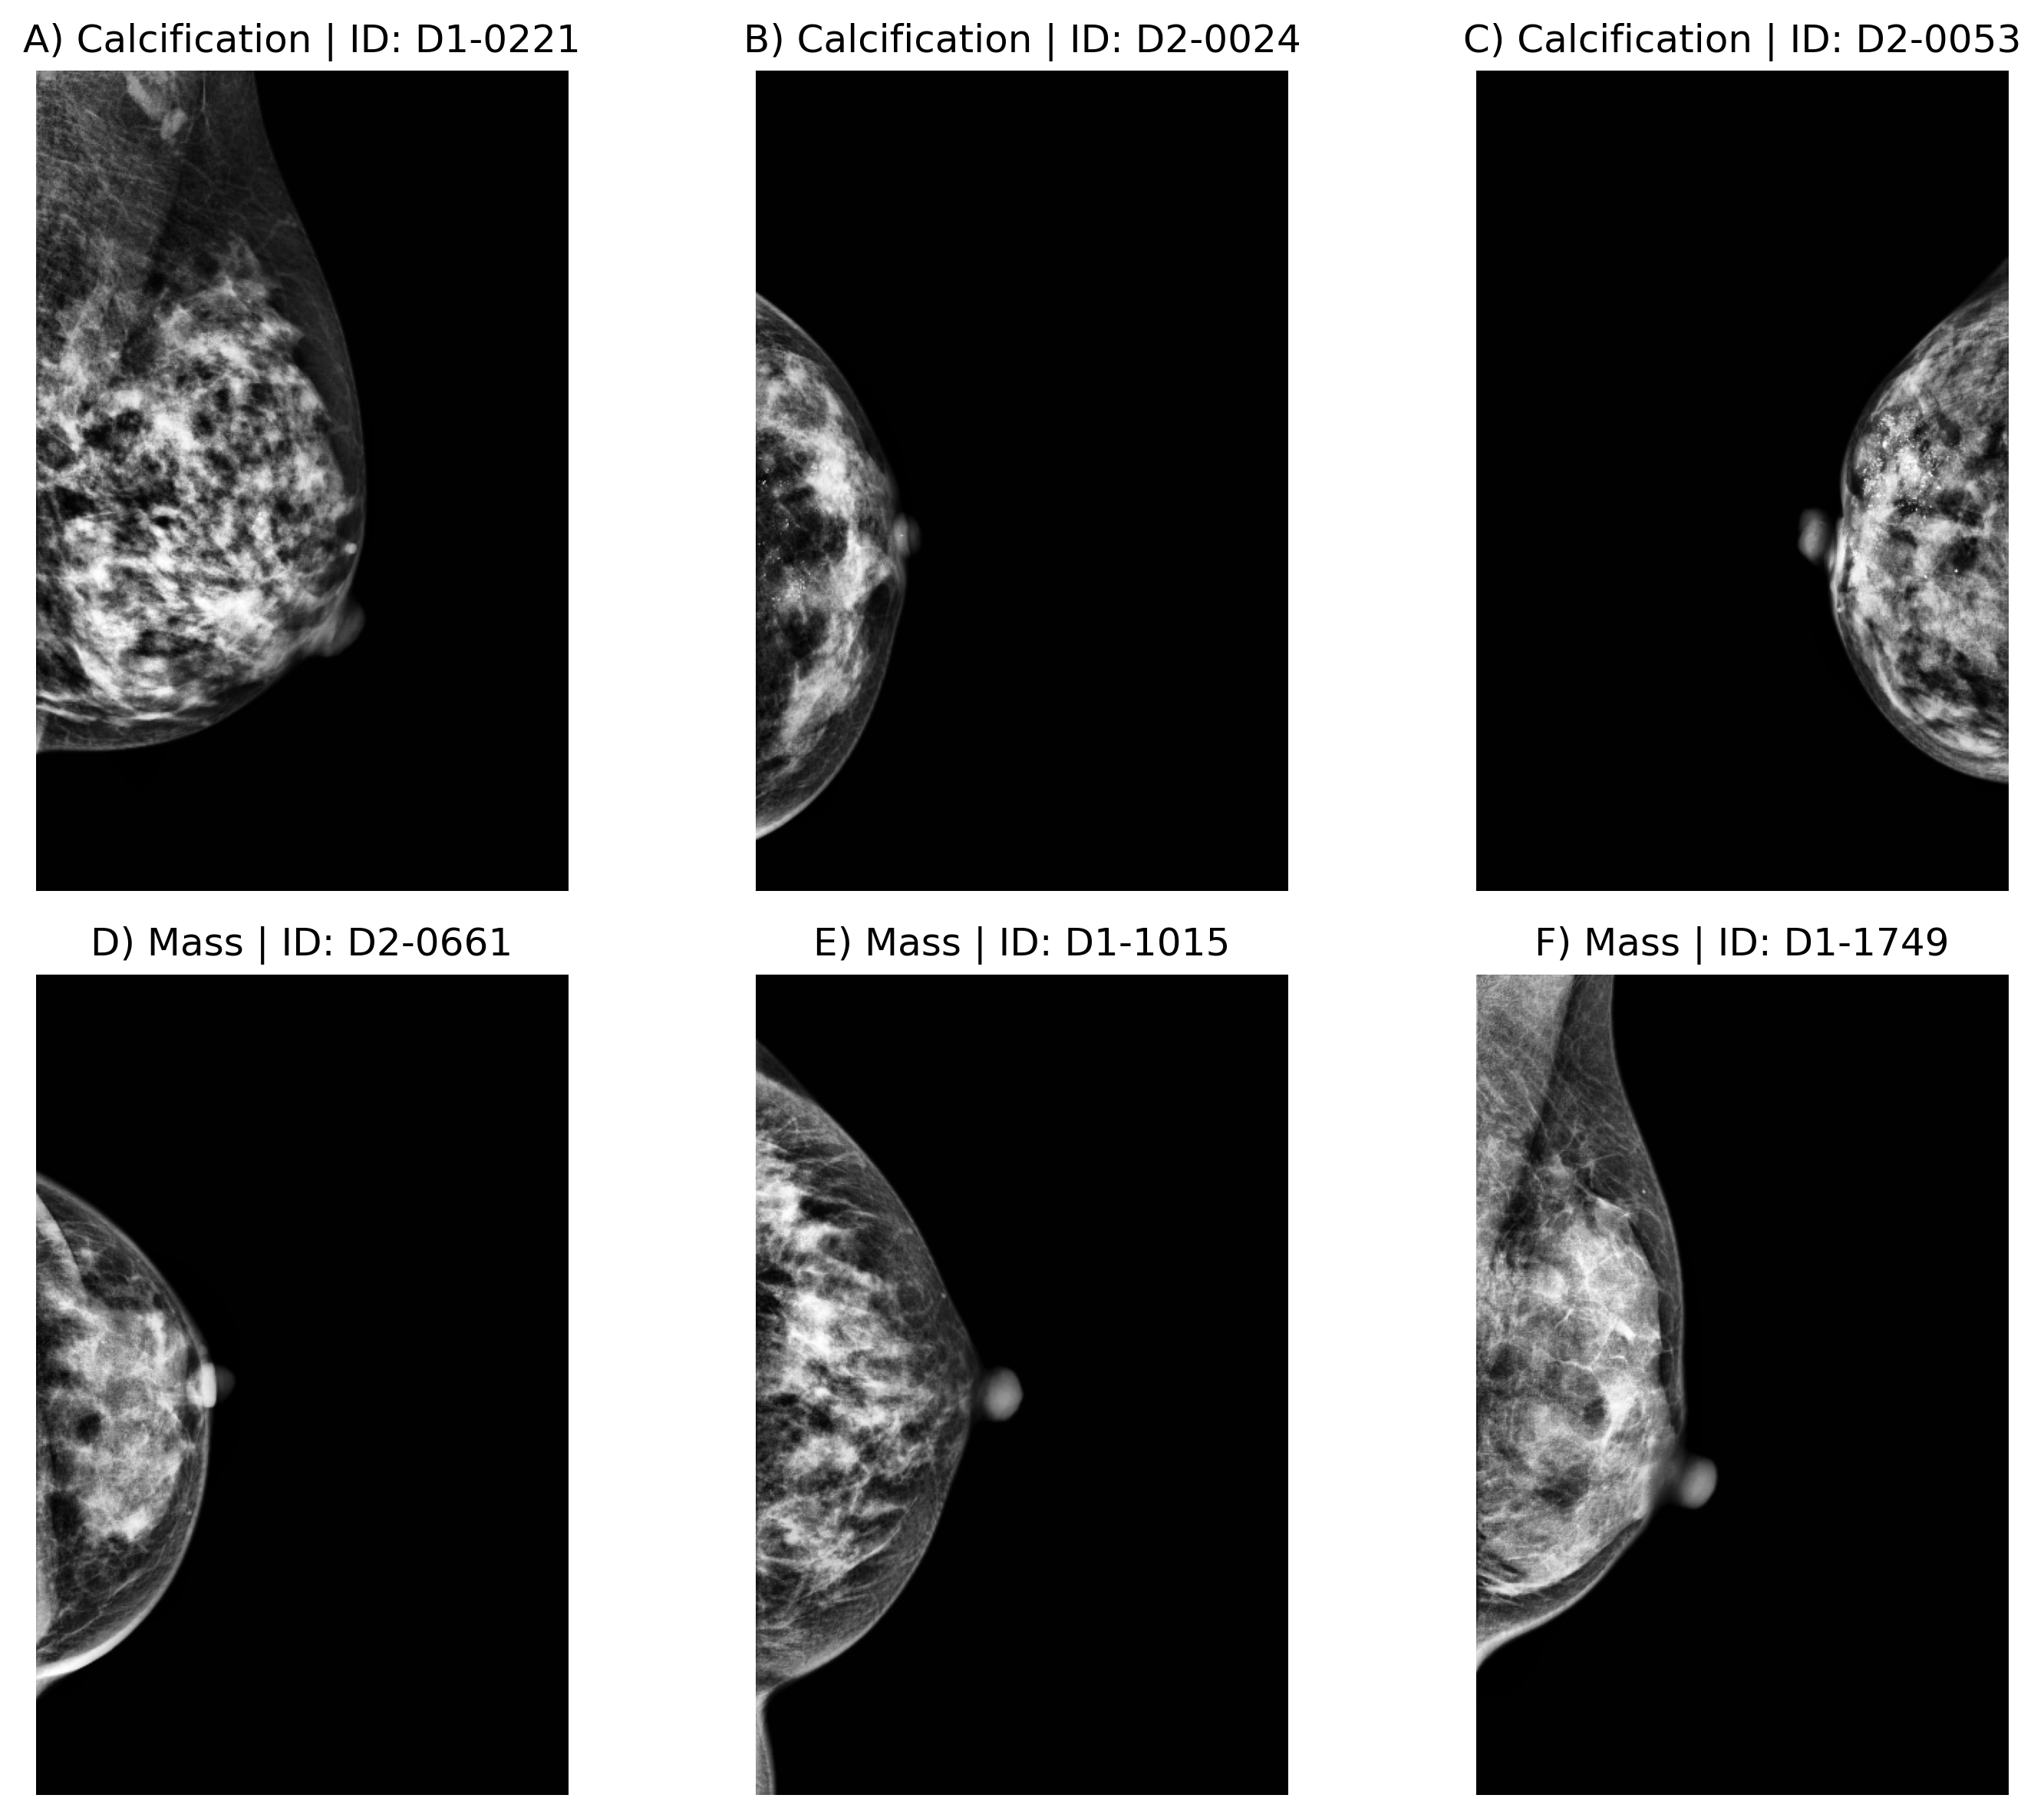

In [46]:
import string

# Select up to 3 random calcification and up to 3 random mass images from df_cmmd
calcification_df = df_cmmd[df_cmmd['abnormality'] == 'calcification']
mass_df = df_cmmd[df_cmmd['abnormality'] == 'mass']

calcification_samples = calcification_df.sample(min(3, len(calcification_df)), random_state=5)
mass_samples = mass_df.sample(min(3, len(mass_df)), random_state=3)

samples = pd.concat([calcification_samples, mass_samples])

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=300)  # Smaller size, higher resolution
axes = axes.flatten()

for idx, (i, row) in enumerate(samples.iterrows()):
    img = np.array(row['pixel_array'])
    letter = string.ascii_uppercase[idx]
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"{letter}) {row['abnormality'].capitalize()} | ID: {row['ID1']}", fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Example of patient with four images

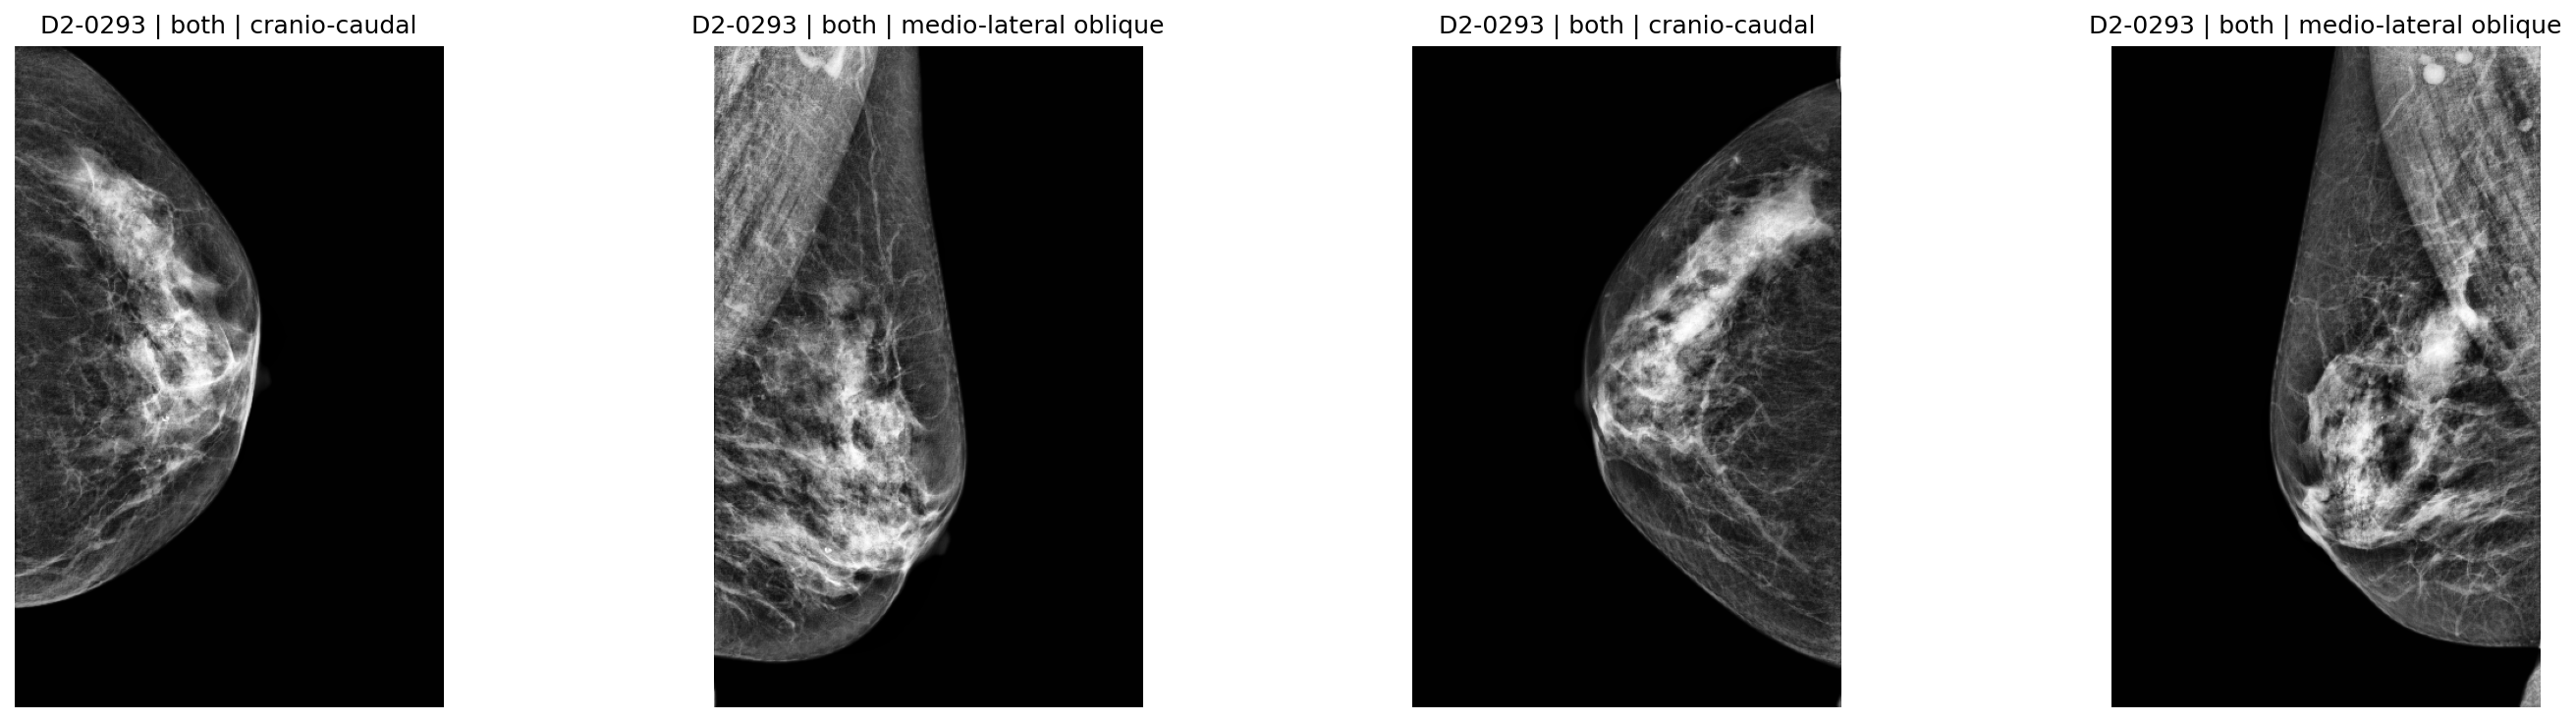

In [47]:
# Filter the dataframe for the given ID1
df_selected = df_cmmd[df_cmmd['ID1'] == 'D2-0293']

# Plot all images for this ID1
fig, axes = plt.subplots(1, len(df_selected), figsize=(5 * len(df_selected), 5), dpi=150)
if len(df_selected) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, df_selected.iterrows()):
    img = np.array(row['pixel_array'])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{row['ID1']} | {row['abnormality']} | {row['code_meaning']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Shows enhancement steps and detection process of ROIs

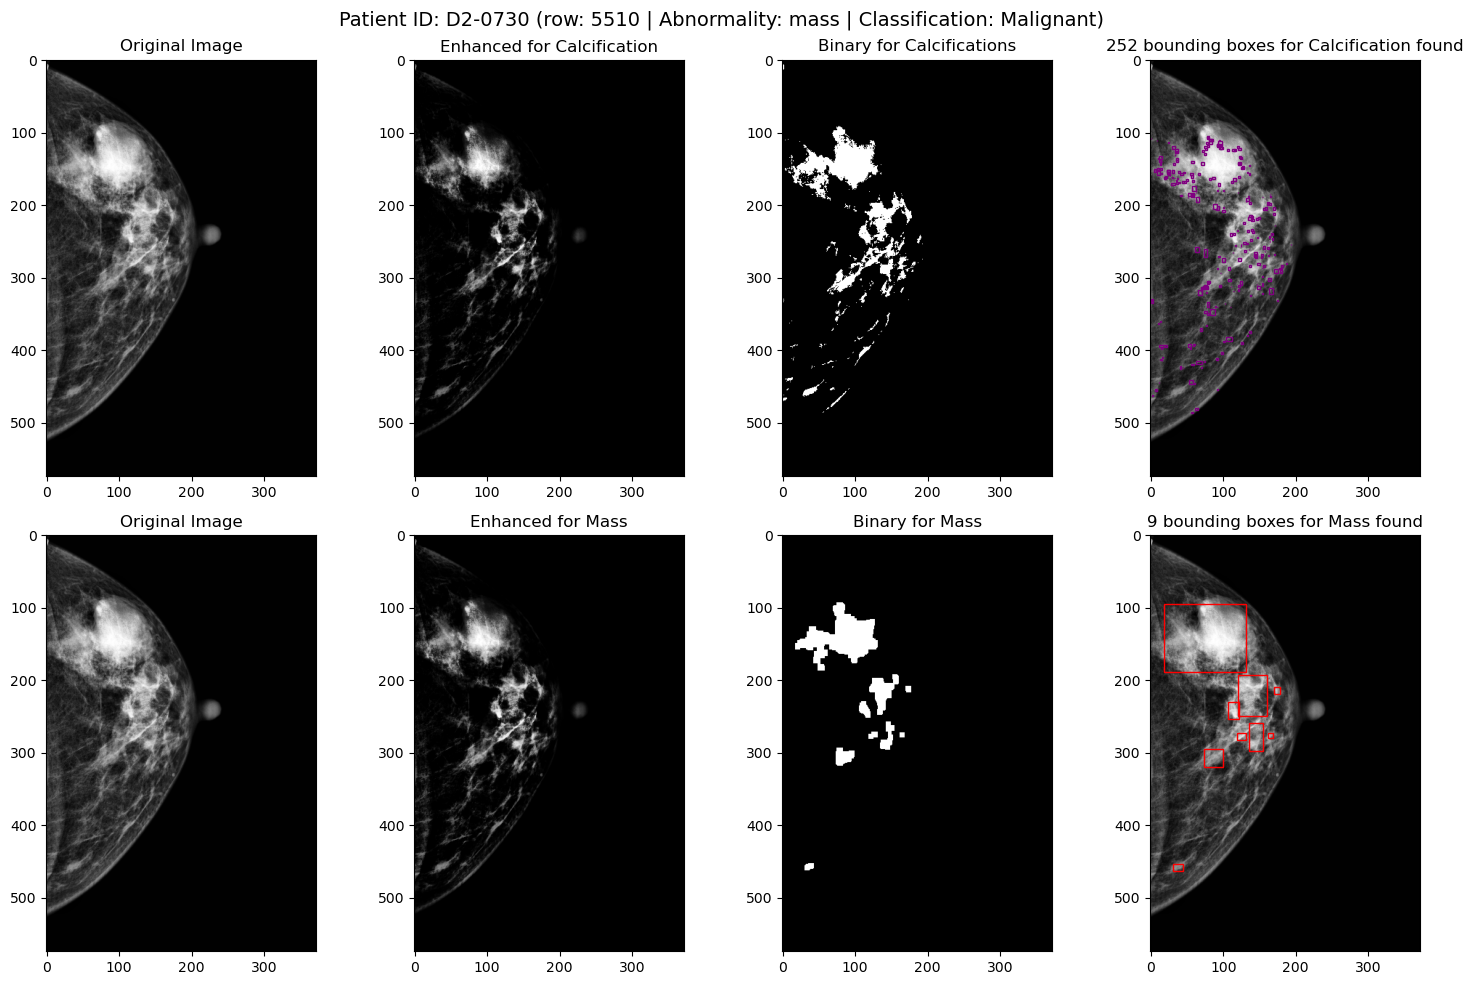

In [50]:
importlib.reload(showcase_and_graphs)

showcase_and_graphs.plot_contours_results(df_cmmd)

### Compare histogram equalization


Category mapping for column 'image_laterality':
{0: 'L', 1: 'R'}

Category mapping for column 'patient_orientation':
{0: "'A', 'FR'", 1: "'A', 'R'", 2: "'P', 'FL'", 3: "'P', 'L'"}

Category mapping for column 'code_meaning':
{0: 'cranio-caudal', 1: 'medio-lateral oblique'}

Category mapping for column 'classification':
{0: 'Benign', 1: 'Malignant'}

Category mapping for column 'subtype':
{0: 'missing'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID1                  2484 non-null   string  
 1   pixel_array          2484 non-null   object  
 2   image_laterality     2484 non-null   category
 3   patient_orientation  2484 non-null   category
 4   code_meaning         2484 non-null   category
 5   Age                  2484 non-null   Int32   
 6   number               2484 non-null   Int32   
 7   abnormality          2

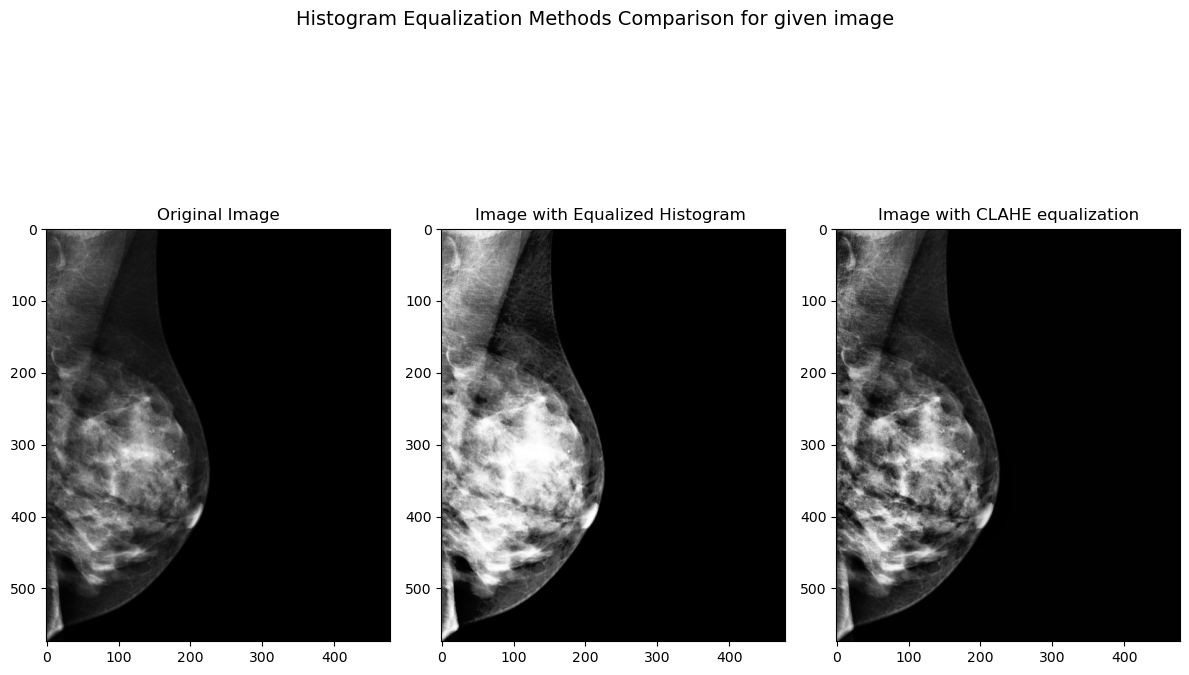

In [51]:
# Compare normal image vs equalized image vs clahe image
# Note: if no image is passed, a sample of df_cmmd is loaded
# and a random image is selected from it.

importlib.reload(showcase_and_graphs)
showcase_and_graphs.plot_histogram_equalization()

# Feature Engineering

### Separately load features when AOI function was not executed

In [ ]:
# importlib.reload(feature_engineering)

# features_df = feature_engineering.feature_extractor(df_cmmd,
#                                                     workers=10,
#                                                     hist_equalize='adaptive',
#                                                     chunksize=None,
#                                                     df_image_column='pixel_array',
#                                                     df_id_column='ID1',
#                                                     quantize=64,
#                                                     laplace_fct=0.2,
#                                                     sigma_gauss_calci=0.1,
#                                                     sigma_gauss_mass=0.3,
#                                                     gamma_calci=0.3,
#                                                     gamma_mass=0.4,
#                                                     kernel_mass=2,
#                                                     max_thresh_contour_calci=3**2,
#                                                     max_thresh_contour_mass=120**2,
#                                                     morph_open_iter=3,
#                                                     morph_close_iter=2,
#                                                     max_contours_per_type=200,  # CRITICAL: Limit contours processed
#                                                     simplified_glcm=True,     # CRITICAL: Use single angle/distance
#                                                     enable_texture_features=True  # Set False for 50x speedup
#                                                     )
# features_df.head()

# # Store features_df to pickle file

# # features_df.to_pickle('features_df.pkl')

Using chunksize: 1


num_roi_calci  count_px_calci  mean_px_calci  std_px_calci  min_px_calci  \
0            200           3.975     190.500595        9.4344    175.695007   

   max_px_calci  skewness_px_calci  kurtosis_px_calci  area_calci  \
0    203.065002            -0.0808            -0.4661       3.975   

   perimeter_calci  ...  correlation_texture_mass  ASM_texture_mass  \
0           3.4317  ...                    0.9238            0.9956   

   entropy_texture_mass  variance_texture_mass  glcm_mass_skewness  \
0                 0.038                 0.0002             14.9688   

   glcm_mass_kurtosis  log_contrast_texture_mass  \
0              246.25                     0.4333   

   log_homogeneity_texture_mass  log_dissimilarity_texture_mass  \
0                        0.6924                          0.0177   

   log_correlation_texture_mass  
0                        0.6538  

[1 rows x 54 columns]

In [9]:
# To load the DataFrame later, use:
features_df_v3 = pd.read_pickle('features_df_v3_clahe.pkl')
features_df_v3

num_roi_calci  count_px_calci  mean_px_calci  std_px_calci  \
0               184          3.9565     188.697601        9.5846   
1               200          3.9200     188.661697        8.6713   
2               200          4.5300     191.510803        9.5187   
3               200          4.1150     192.716995        8.6880   
4               200          4.1550     187.761093        7.7885   
...             ...             ...            ...           ...   
5585            200          4.0550     168.113495        4.4718   
5586            135          4.5630     163.833496        6.3370   
5587            200          4.9950     164.352493        6.8752   
5588            177          4.9040     158.070999        5.9256   
5589            200          4.3700     163.719894        5.9148   

      min_px_calci  max_px_calci  skewness_px_calci  kurtosis_px_calci  \
0       173.690201    201.168503            -0.1221            -0.4765   
1       176.000000    200.104996            -0.0549            -0.4982   
2       176.955002    204.755005            -0.0576            -0.4647   
3       179.865005    204.595001            -0.0428            -0.5872   
4       176.205002    198.110001            -0.0544            -0.5625   
...            ...           ...                ...                ...   
5585    162.039993    174.610001             0.0514            -0.4860   
5586    154.592606    172.866699            -0.0213            -0.6158   
5587    154.289993    174.664993            -0.0126            -0.5185   
5588    149.502808    167.124298             0.0620            -0.5328   
5589    155.309998    172.740005             0.0341            -0.4845   

      area_calci  perimeter_calci  ...  correlation_texture_mass  \
0         3.9565           3.4426  ...                    0.9307   
1         3.9200           3.3525  ...                    0.9146   
2         4.5300           3.9114  ...                    0.9243   
3         4.1150           3.5692  ...                    0.9297   
4         4.1550           3.5140  ...                    0.9380   
...          ...              ...  ...                       ...   
5585      4.0550           3.3461  ...                    0.9292   
5586      4.5630           4.2832  ...                    0.9194   
5587      4.9950           4.4405  ...                    0.9170   
5588      4.9040           4.3365  ...                    0.9111   
5589      4.3700           3.8208  ...                    0.9297   

      ASM_texture_mass  entropy_texture_mass  variance_texture_mass  \
0               0.9946                0.0475                 0.0002   
1               0.9951                0.0406                 0.0002   
2               0.9951                0.0412                 0.0002   
3               0.9941                0.0517                 0.0002   
4               0.9927                0.0608                 0.0002   
...                ...                   ...                    ...   
5585            0.9941                0.0511                 0.0002   
5586            0.9868                0.1026                 0.0002   
5587            0.9937                0.0510                 0.0002   
5588            0.9922                0.0627                 0.0002   
5589            0.9941                0.0496                 0.0002   

      glcm_mass_skewness  glcm_mass_kurtosis  log_contrast_texture_mass  \
0                15.5078             257.750                     0.4600   
1                14.7812             235.000                     0.4219   
2                16.0625             272.750                     0.4829   
3                16.1250             281.500                     0.5049   
4                17.3906             332.500                     0.5112   
...                  ...                 ...                        ...   
5585             15.0234             249.375                     0.3481   
5586             16.0000      

### Prepare Train-Test-Split and Encode data (if AOI not executed)

In [12]:
import feature_encoding_selection
from feature_encoding_selection import config
from sklearn.model_selection import train_test_split

importlib.reload(fes)


X = features_df_v3
X.insert(0, 'age', df_cmmd_save['Age'])
X.insert(0, 'laterality', df_cmmd_save['image_laterality'])
X.insert(0, 'subtype', df_cmmd_save['subtype'])
X.insert(0, 'code_meaning', df_cmmd_save['code_meaning'])

X = fes.encode_and_standardize(X)

# Class, i.e. target variable y
# classification_labels = df_cmmd_save
#['classification'].astype('category')
cat_encoder = skp.OneHotEncoder(drop='first')  # Use drop='first' to avoid dummy variable trap
y = cat_encoder.fit_transform(df_cmmd_save[['classification']]).toarray()
y = y.ravel()

In [13]:
classification_labels = df_cmmd_save['classification'].astype('category')
subtype_labels = df_cmmd_save['subtype'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = config.RANDOM_STATE,
                                                    shuffle = True,
                                                    stratify = y
                                                    )

## For Feature Selection Purposes

### If AOI was executed

                                              age  num_roi_calci  \
age                                  1.000000e+00      -0.103119   
num_roi_calci                       -1.031193e-01       1.000000   
count_px_calci                      -1.016379e-01      -0.223303   
mean_px_calci                        2.523799e-01      -0.554822   
std_px_calci                        -1.881070e-01       0.117087   
min_px_calci                         2.777311e-01      -0.556194   
max_px_calci                         2.256320e-01      -0.542483   
skewness_px_calci                    2.200172e-01      -0.153364   
kurtosis_px_calci                    1.389992e-01       0.220515   
area_calci                          -1.016379e-01      -0.223303   
perimeter_calci                     -1.713630e-01      -0.220351   
eccentricity_calci                   3.388554e-01      -0.013356   
solidity_calci                      -2.507278e-01      -0.095399   
extent_calci                         2.234786e-0

<Axes: >

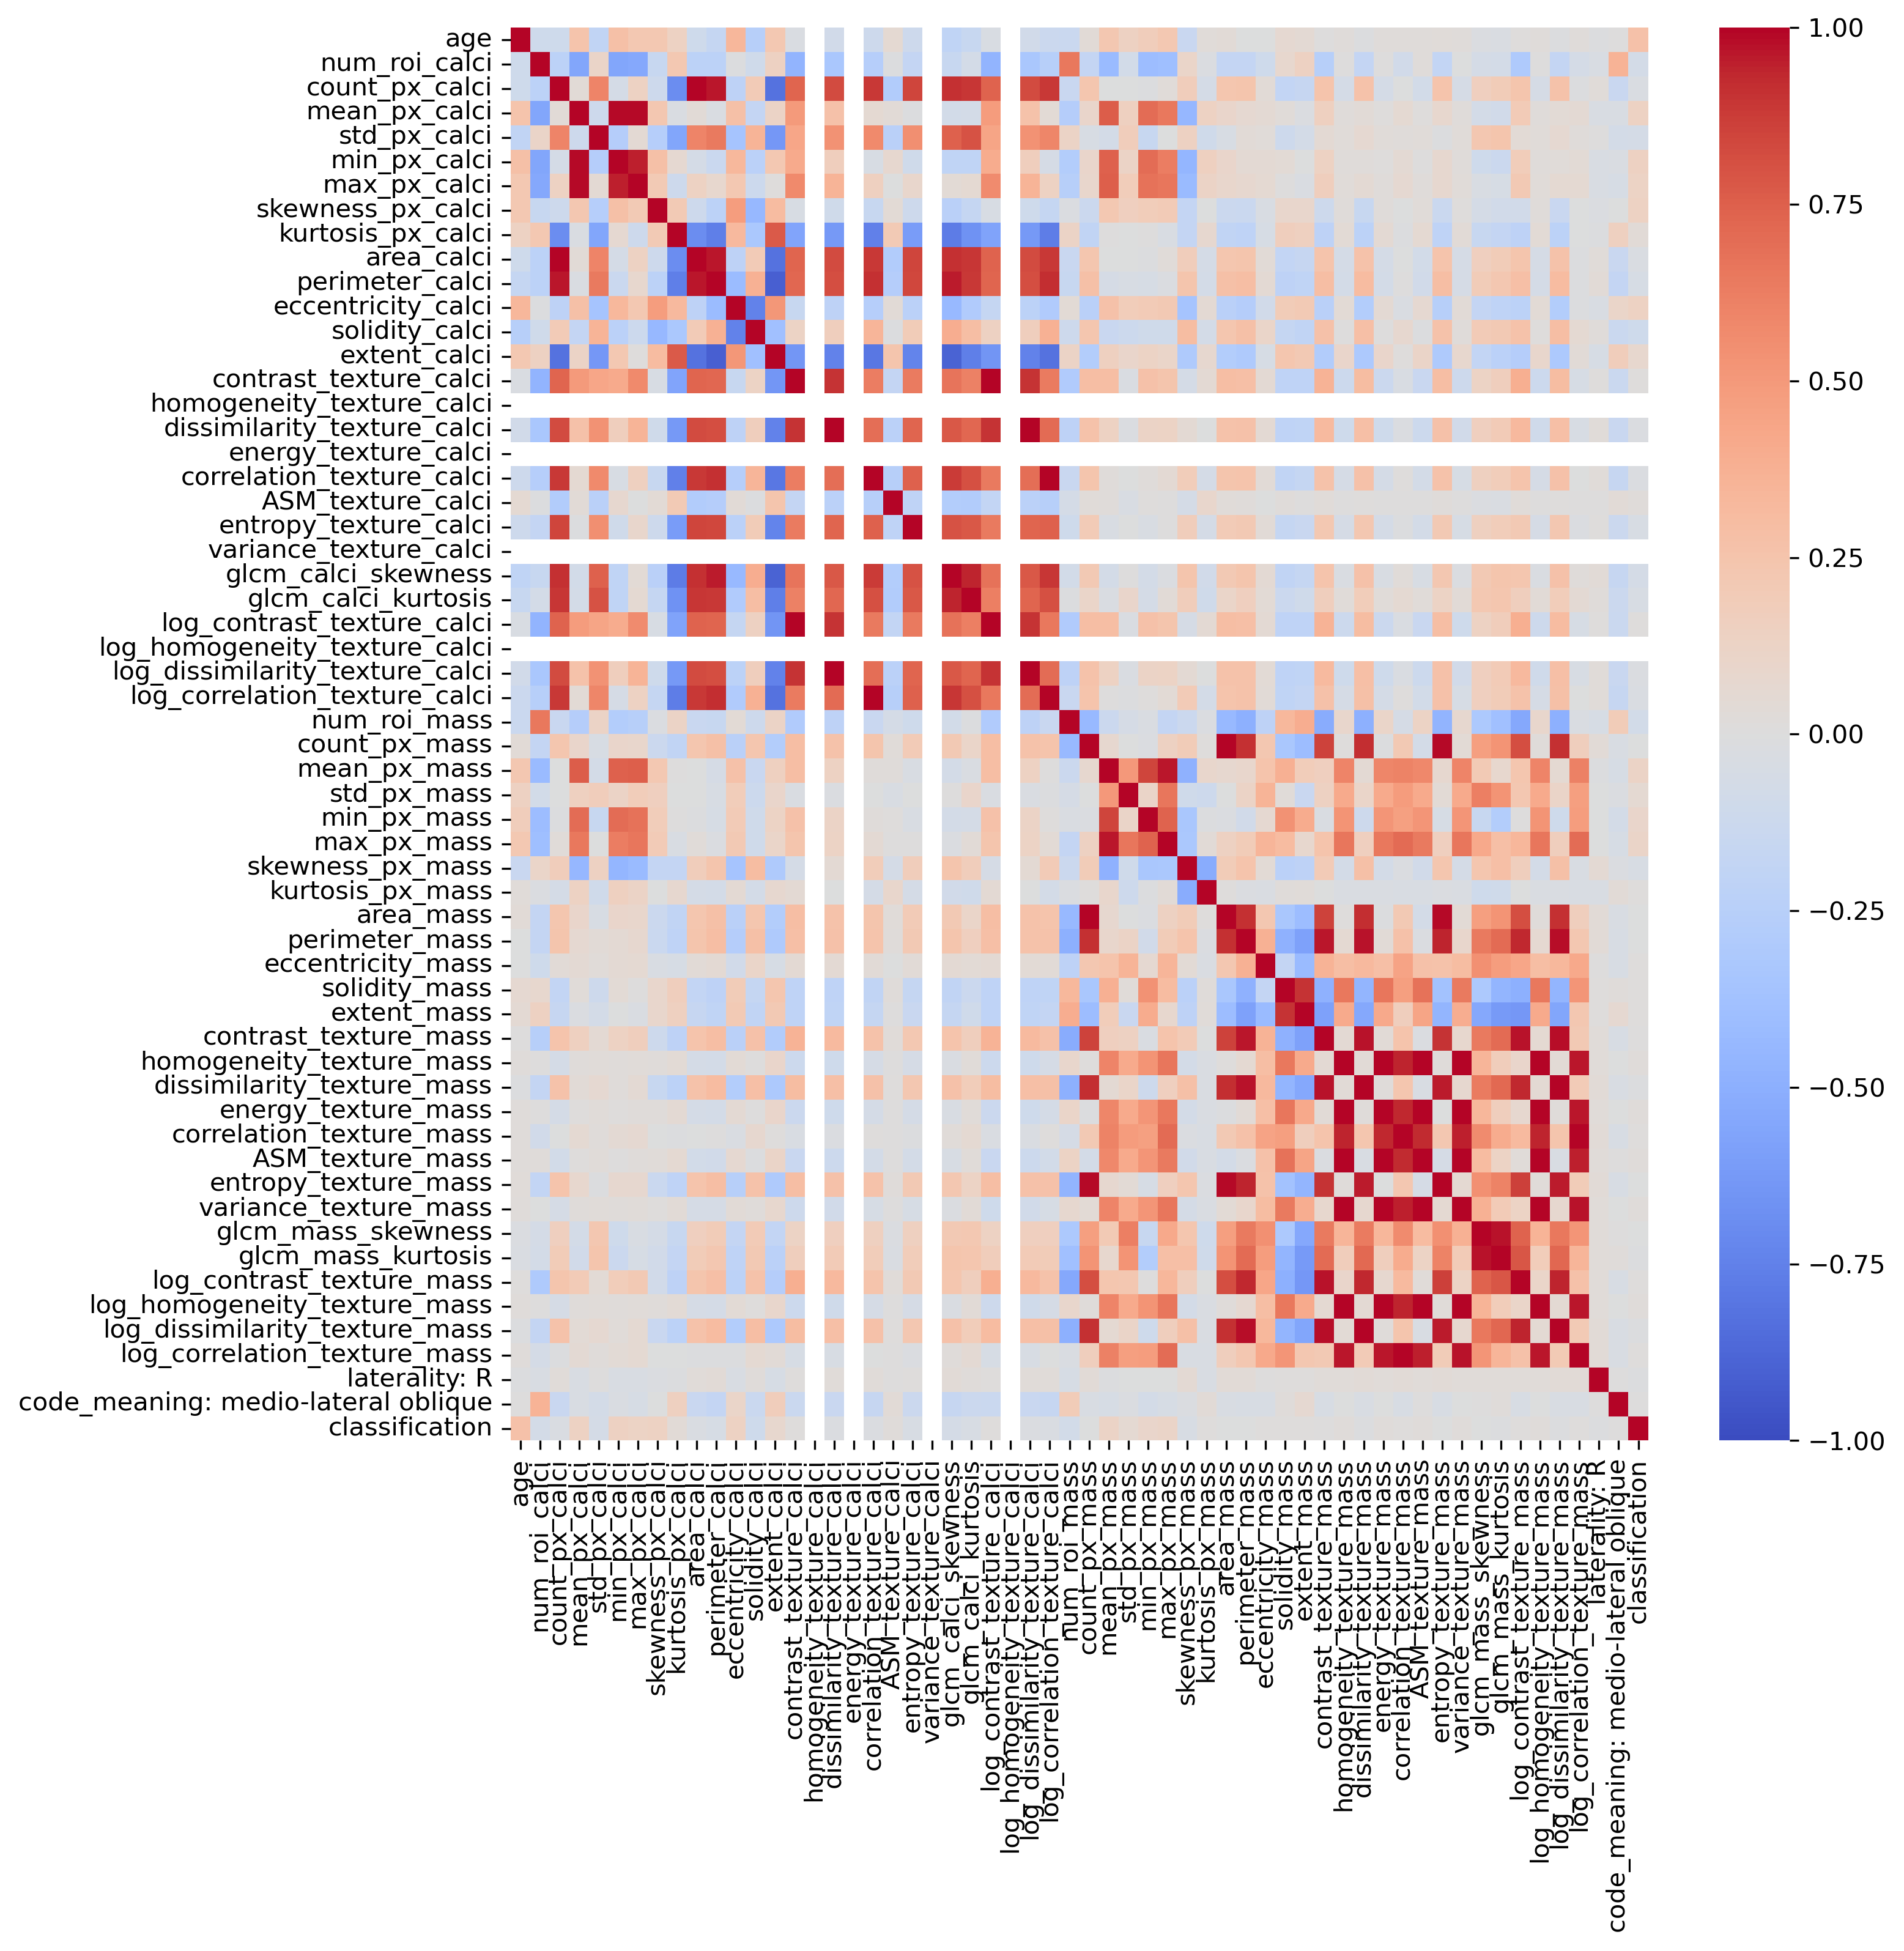

In [31]:
# Set up the features and target variable
X = features_df
y = df_cmmd['classification'].astype('category').cat.codes

# To analyze the correlation between features and the target variable
# Concatenate features and target variable for correlation analysis
Xy = pd.concat([features_df, pd.Series(y, name='classification')], axis=1)

corr_matrix = Xy.corr()
print(corr_matrix)

# Seaborn Heatmap
fig, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

sns.heatmap(corr_matrix,vmin=-1, vmax=1, cmap="coolwarm",
            xticklabels=True, yticklabels=True, ax=axes, robust=True) #'coolwarm' before;

### If AOI was not executed

                                 code_meaning       subtype    laterality  \
code_meaning                     1.000000e+00 -3.906112e-17  5.682598e-18   
subtype                         -3.906112e-17  1.000000e+00 -1.848159e-02   
laterality                       5.682598e-18 -1.848159e-02  1.000000e+00   
age                              7.784503e-18 -1.538000e-01 -1.283698e-02   
num_roi_calci                    2.947678e-01 -2.417611e-03 -2.116695e-02   
count_px_calci                  -1.201757e-01  2.088192e-02  1.163373e-02   
mean_px_calci                   -4.516981e-02 -3.219708e-02 -3.111152e-02   
std_px_calci                    -6.809232e-02  7.572713e-03  1.554904e-02   
min_px_calci                    -3.000809e-02 -3.557204e-02 -3.516341e-02   
max_px_calci                    -5.446833e-02 -3.045260e-02 -2.738420e-02   
skewness_px_calci                9.344562e-02 -4.494921e-02 -3.980302e-02   
kurtosis_px_calci                1.389863e-01 -1.421894e-02 -1.642516e-02   

<Axes: >

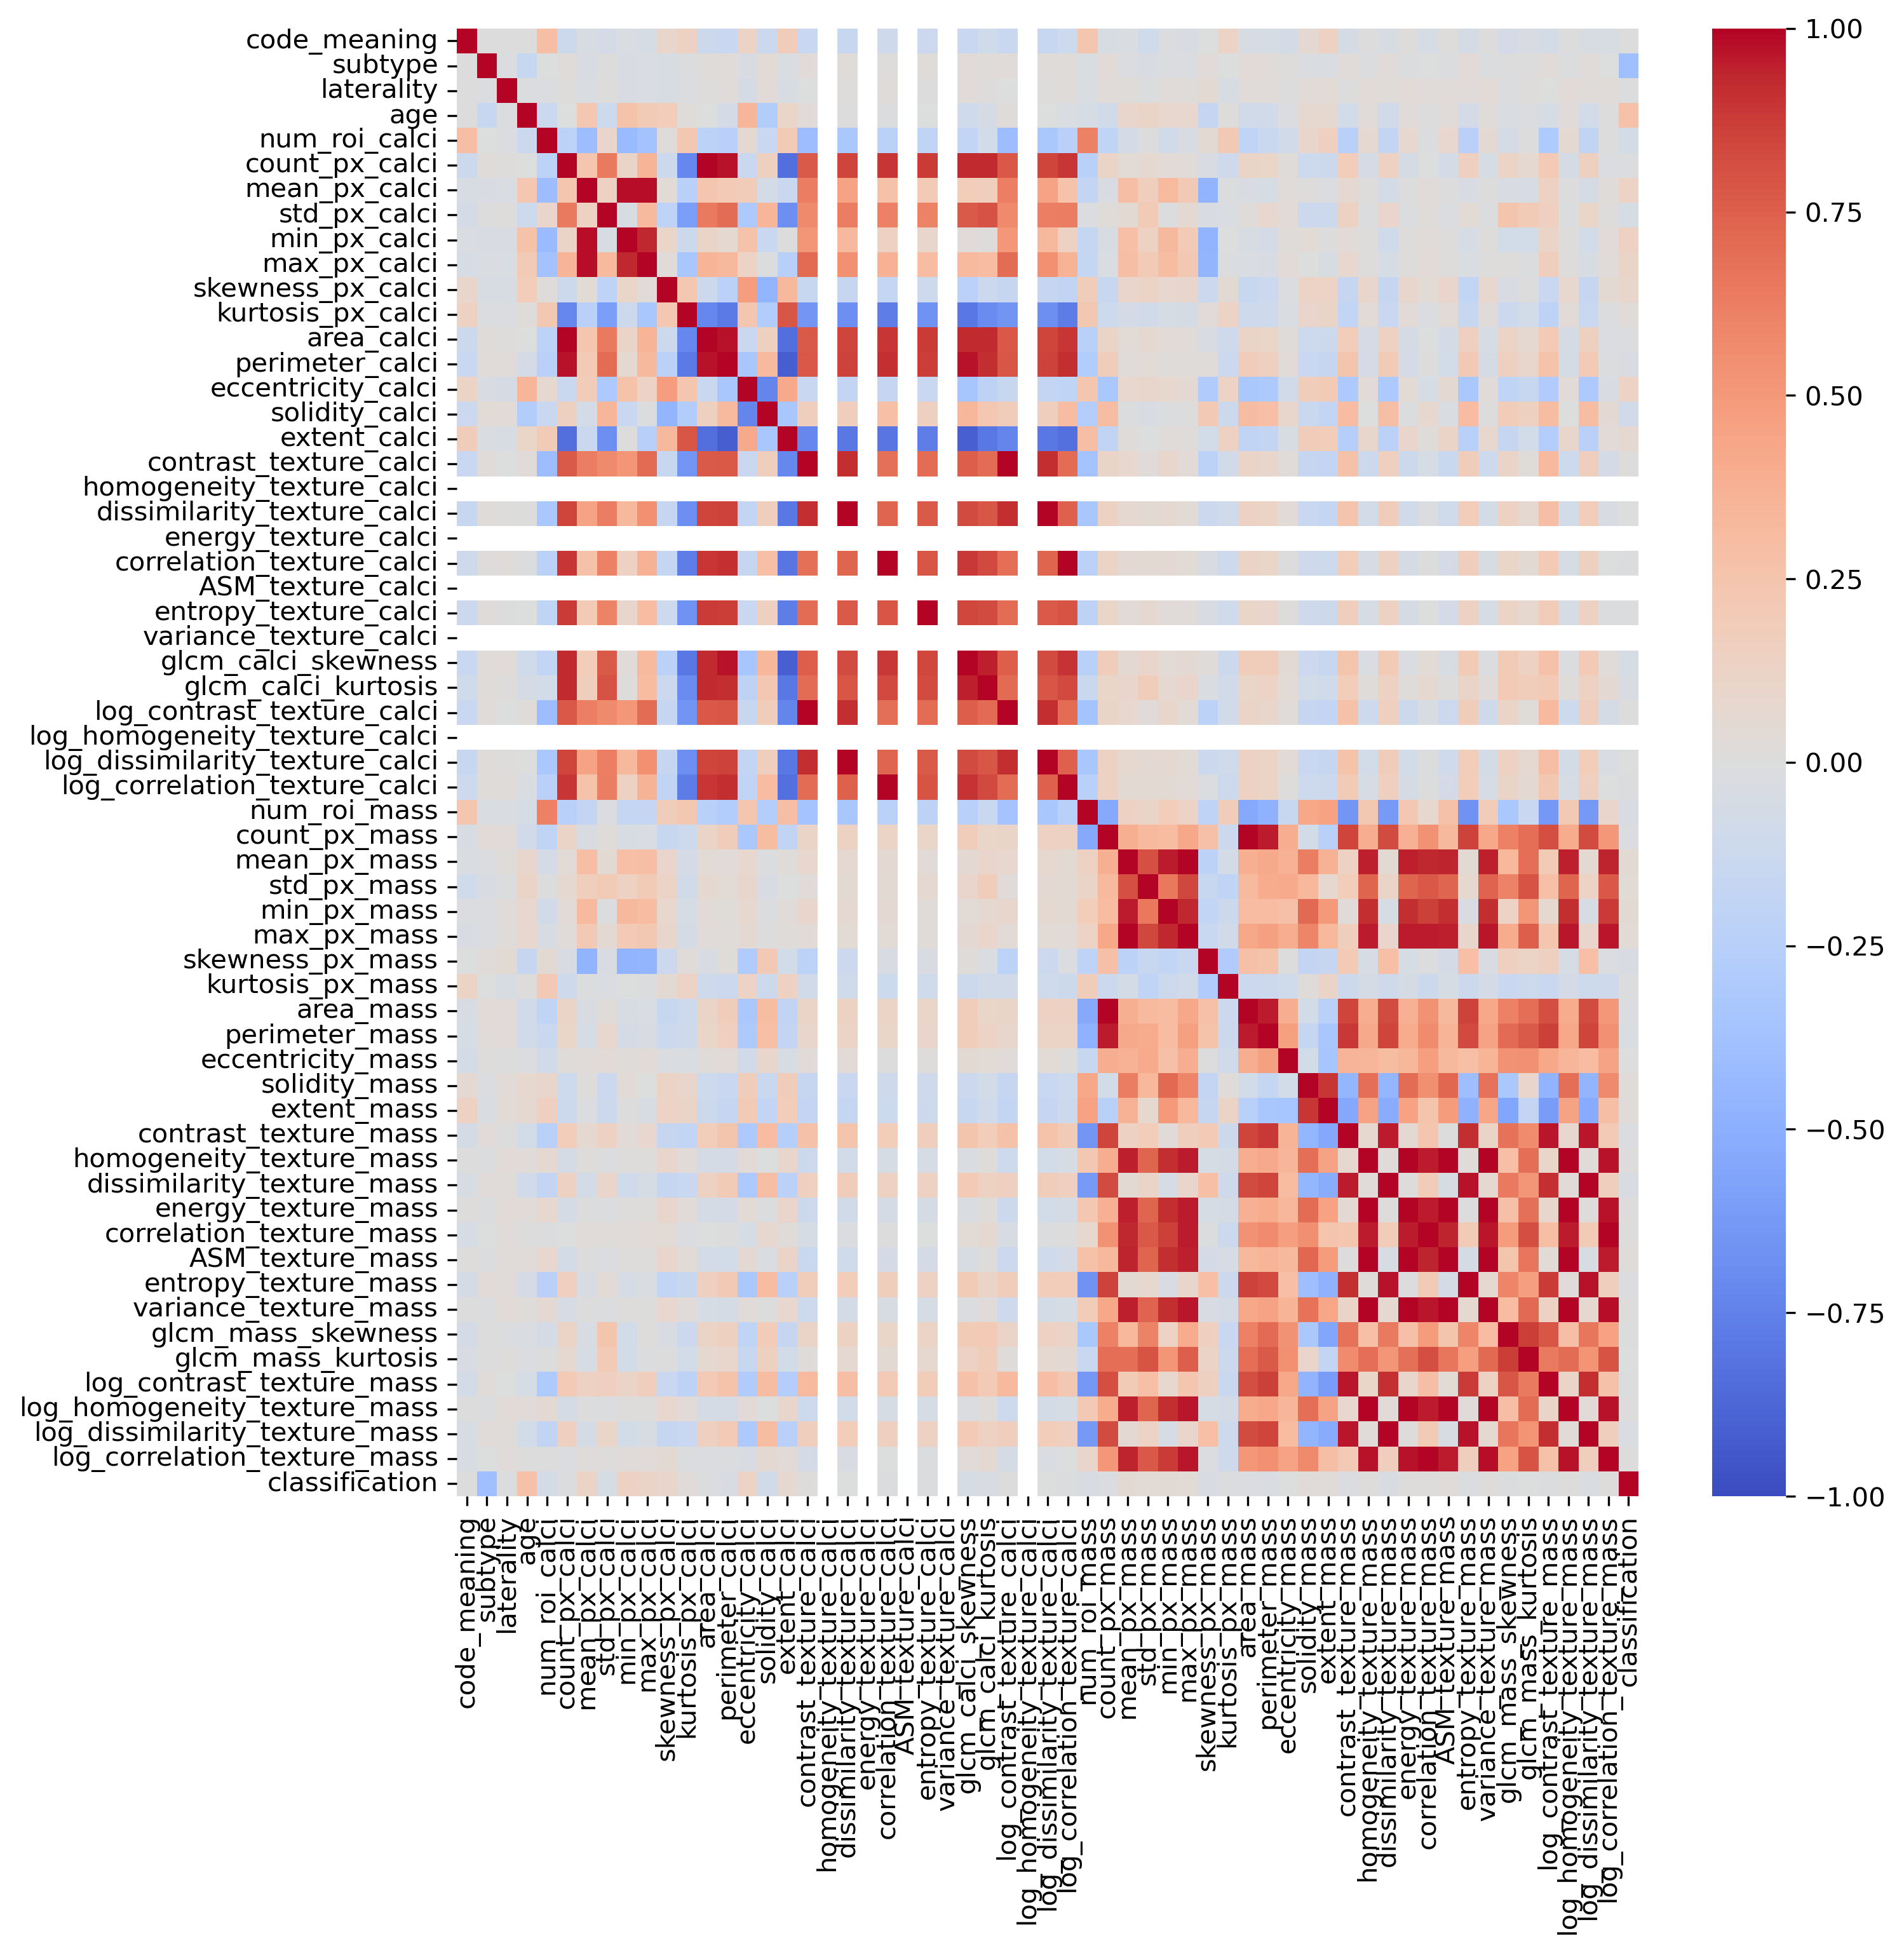

In [14]:
# Show Correlation Matrix of features
import seaborn as sns

# Set up the features and target variable
X = features_df_v3
y = df_cmmd_save['classification'].astype('category').cat.codes

# Convert catergorical variables to numerical for correlation analysis
X['laterality'] = X['laterality'].astype('category').cat.codes
X['age'] = X['age'].astype('int')
X['subtype'] = X['subtype'].astype('category').cat.codes
X['code_meaning'] = X['code_meaning'].astype('category').cat.codes

# To analyze the correlation between features and the target variable
# Concatenate features and target variable for correlation analysis
Xy = pd.concat([features_df_v3, pd.Series(y, name='classification')], axis=1)

corr_matrix = Xy.corr()
print(corr_matrix)

# Seaborn Heatmap
fig, axes = plt.subplots(1, 1, figsize=(10, 10), dpi=300)

sns.heatmap(corr_matrix,vmin=-1, vmax=1, cmap="coolwarm",
            xticklabels=True, yticklabels=True, ax=axes, robust=True) #'coolwarm' before;

## Feature Selection (not applied in final version)

### Correlation Analysis

In [32]:
# Feature Selection based on Correlation
importlib.reload(fes)

feature_select, corr = fes.select_correlated_features(corr_matrix, 'classification', threshold=0.01)

for feature, corr_value in zip(feature_select, corr):
    print(f"Feature: {feature} | Corr: {corr_value:.2f}")


Feature: age | Corr: 0.27
Feature: min_px_calci | Corr: 0.15
Feature: mean_px_calci | Corr: 0.14
Feature: skewness_px_calci | Corr: 0.14
Feature: eccentricity_calci | Corr: 0.13
Feature: max_px_calci | Corr: 0.13
Feature: mean_px_mass | Corr: 0.12
Feature: max_px_mass | Corr: 0.12
Feature: min_px_mass | Corr: 0.10
Feature: extent_calci | Corr: 0.08
Feature: std_px_mass | Corr: 0.06
Feature: kurtosis_px_calci | Corr: 0.03
Feature: ASM_texture_calci | Corr: 0.02
Feature: ASM_texture_mass | Corr: 0.02
Feature: homogeneity_texture_mass | Corr: 0.02
Feature: log_homogeneity_texture_mass | Corr: 0.02
Feature: energy_texture_mass | Corr: 0.02
Feature: variance_texture_mass | Corr: 0.02
Feature: log_correlation_texture_mass | Corr: 0.02
Feature: solidity_mass | Corr: 0.01
Feature: correlation_texture_mass | Corr: 0.01
Feature: extent_mass | Corr: 0.01
Feature: log_contrast_texture_mass | Corr: 0.01
Feature: kurtosis_px_mass | Corr: 0.01
Feature: eccentricity_mass | Corr: 0.01
Feature: contrast

### Recursive Feature Elimination

In [33]:
# Recursive Feature Elimination (RFE) for feature selection
importlib.reload(fes)

selected_features_rfe = fes.select_features_rfe(X, y, n_features=20)
print("Selected features using RFE:")
print(selected_features_rfe)

c:\Users\norma\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\norma\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

20 features selected based on mutual information.
Selected features using RFE:
Index(['count_px_calci', 'mean_px_calci', 'min_px_calci', 'max_px_calci',
       'kurtosis_px_calci', 'area_calci', 'perimeter_calci',
       'eccentricity_calci', 'solidity_calci', 'contrast_texture_calci',
       'correlation_texture_calci', 'glcm_calci_skewness',
       'log_contrast_texture_calci', 'log_correlation_texture_calci',
       'skewness_px_mass', 'solidity_mass', 'extent_mass',
       'contrast_texture_mass', 'entropy_texture_mass',
       'log_contrast_texture_mass'],
      dtype='object')


### Mutual Information Selection

In [34]:
importlib.reload(fes)

# Example usage:
selected_features_mi = fes.select_features_by_mutual_info(X, y, mi_threshold=0.15)
for row in selected_features_mi.itertuples(index=False):
    print(f"Feature: {row.feature} | MI: {row.mutual_info:.2f}")
    
selected_features_mi = selected_features_mi['feature'].tolist()


c:\Users\norma\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\norma\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\norma\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\norma\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\nor

19 features selected based on mutual information.
Feature: mean_px_calci | MI: 0.53
Feature: min_px_calci | MI: 0.53
Feature: max_px_calci | MI: 0.53
Feature: std_px_calci | MI: 0.51
Feature: glcm_calci_kurtosis | MI: 0.49
Feature: perimeter_calci | MI: 0.48
Feature: count_px_calci | MI: 0.43
Feature: area_calci | MI: 0.43
Feature: glcm_calci_skewness | MI: 0.41
Feature: skewness_px_mass | MI: 0.29
Feature: kurtosis_px_calci | MI: 0.25
Feature: area_mass | MI: 0.25
Feature: count_px_mass | MI: 0.25
Feature: eccentricity_calci | MI: 0.23
Feature: skewness_px_calci | MI: 0.21
Feature: kurtosis_px_mass | MI: 0.20
Feature: contrast_texture_mass | MI: 0.20
Feature: perimeter_mass | MI: 0.20
Feature: log_contrast_texture_mass | MI: 0.16


# Train Model using classifier module

## Apply RandomizedGridSearchCV to find optimal Hyperparameter

In [35]:
# See if class distribution was maintained

# Load the dataset splits
X_train = data_split['X_train']
X_test = data_split['X_test']
y_train = data_split['y_train']
y_test = data_split['y_test']


# Show the distribution of 0 and 1 in y_train
unique, counts = np.unique(y_train, return_counts=True)
distribution = dict(zip(unique, counts))
print("Distribution in y_train:", distribution)

Distribution in y_train: {0: 1116, 1: 3360}


In [37]:
importlib.reload(classifier)

X_train = data_split['X_train']
X_test = data_split['X_test']
y_train = data_split['y_train']
y_test = data_split['y_test']

# Set scorer function and train and evaluate models
param_grids = classifier.create_optimized_parameter_grids()
f2_scoring = classifier.create_custom_scorer()

results, summary_df = classifier.train_and_evaluate_models_random(X_train, y_train, param_grids, n_iter=20, scoring=f2_scoring)
print(summary_df)


Optimizing SGD...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimizing Logistic...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\norma\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\norma\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\norma\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\norma\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fi


Optimizing RandomForest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimizing KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\norma\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Optimizing GradientBoosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
              Model Accuracy Precision  Recall      F1      F2 AUC-ROC  \
0               SGD   0.7538    0.7536  0.9985  0.8589  0.9376  0.6300   
1          Logistic   0.7589    0.7647  0.9807  0.8593  0.9282  0.6883   
2      RandomForest   0.8016    0.8059  0.9690  0.8800  0.9314  0.7196   
3               KNN   0.7746    0.8083  0.9173  0.8593  0.8932  0.6449   
4  GradientBoosting   0.7721    0.7702  0.9926  0.8674  0.9384  0.7299   

  Train Time (s)                                        Best Params  
0           7.11  {'classifier__tol': 0.01, 'classifier__penalty...  
1           9.38  {'classifier__tol': 0.01, 'classifier__solver'...  
2          21.45  {'classifier__n_estimators': 100, 'classifier_...  
3           3.45  {'classifier__weights': 'distance', 'classifie...  
4         181.84  {'classifier__subsample': 1.0, 'classifier__n_...  


## In-Sample ROC-AUC Comparison

ValueError: Found input variables with inconsistent numbers of samples: [4476, 4428]

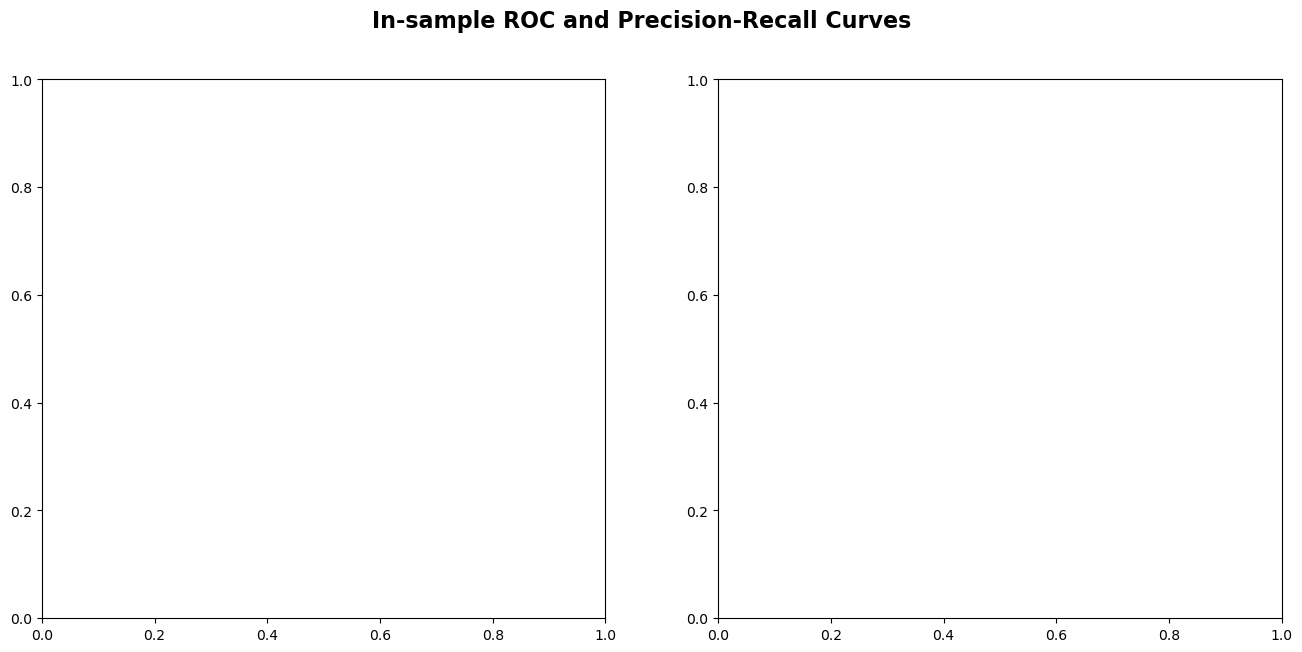

In [36]:
importlib.reload(showcase_and_graphs)
showcase_and_graphs.plot_auc_curves(results, y_train, in_sample=True) 

# Train Model

In [12]:
# # Train the classic classifier with the found parameters
importlib.reload(classifier)
trained_models = classifier.train_best_model_from_summary(X_train, y_train, summary_df, param_grids)

c:\Users\norma\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.85, F2 Score: 0.94
Dummy Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.85, F2 Score: 0.94


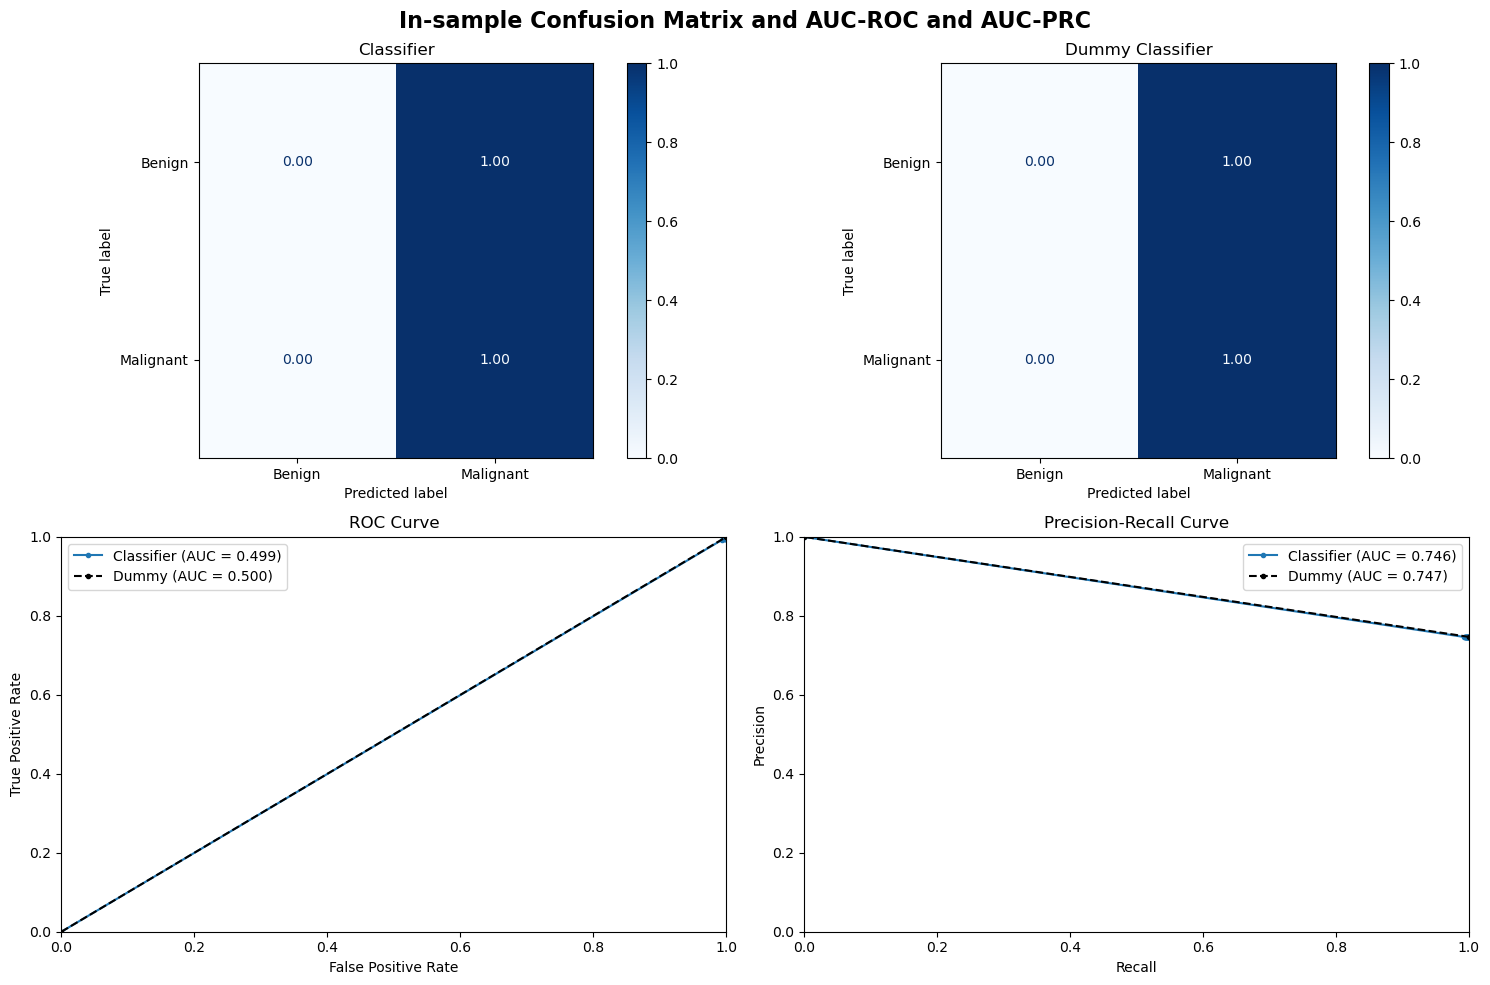

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([1., 1., 1., ..., 1., 1., 1.]),
 'precision': 0.7466124661246613,
 'recall': 1.0,
 'accuracy': 0.7466124661246613,
 'f1': 0.8549262994569433,
 'f2': 0.9364377974167233,
 'confusion_matrix': array([[0., 1.],
        [0., 1.]]),
 'prc': (array([0.74661247, 0.74649797, 0.74644068, 0.7466094 , 0.74655211,
         0.7464948 , 0.74643746, 0.74638009, 0.7463227 , 0.74626528,
         0.74620783, 0.74615036, 0.74609287, 0.74603534, 0.74592022,
         0.74586262, 0.74603175, 0.74591652, 0.74602814, 0.74613987,
         0.74641801, 1.        ]),
  array([1.        , 0.99939504, 0.99909256, 0.99909256, 0.99879008,
         0.9984876 , 0.99818512, 0.99788264, 0.99758016, 0.99727768,
         0.9969752 , 0.99667272, 0.99637024, 0.99606776, 0.99546279,
         0.99516031, 0.99516031, 0.99455535, 0.99425287, 0.99395039,
         0.99274047, 0.        ])),
 'roc': (array([0.        , 0.99376114, 0.99643494, 0.99821747, 0.99821747,
 

In [20]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['SGD'],X_train, y_train, classification_labels, in_sample=True)

Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.85, F2 Score: 0.94
Dummy Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.85, F2 Score: 0.94


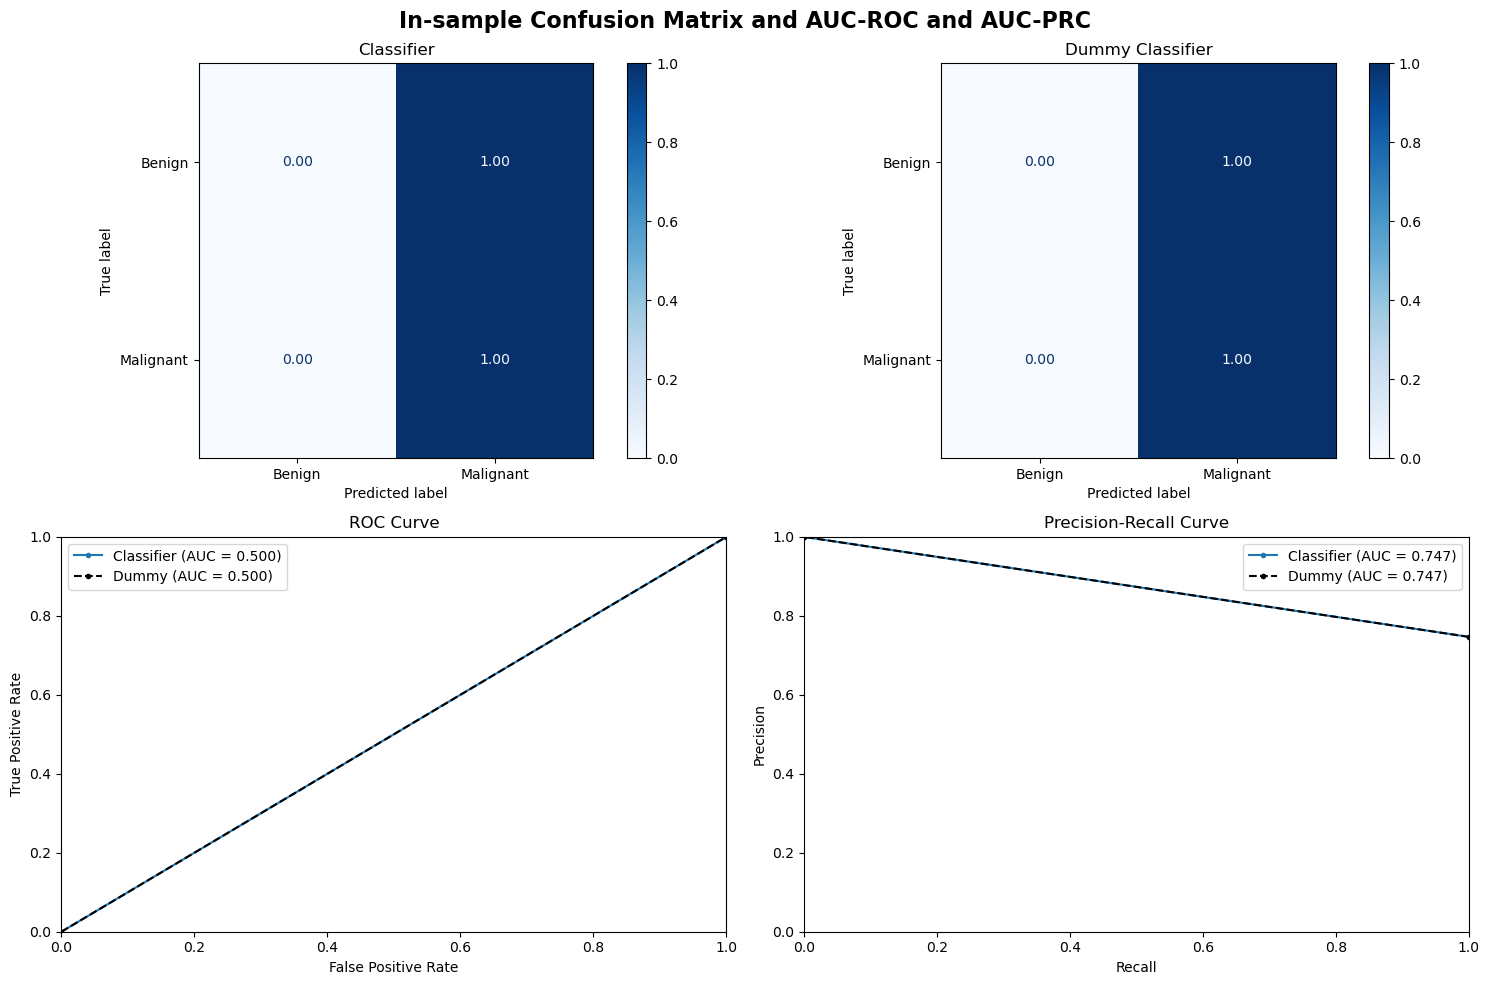

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([1., 1., 1., ..., 1., 1., 1.]),
 'precision': 0.7466124661246613,
 'recall': 1.0,
 'accuracy': 0.7466124661246613,
 'f1': 0.8549262994569433,
 'f2': 0.9364377974167233,
 'confusion_matrix': array([[0., 1.],
        [0., 1.]]),
 'prc': (array([0.74661247, 1.        ]), array([1., 0.])),
 'roc': (array([0., 1.]), array([0., 1.]))}

In [21]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['Logistic'],X_train, y_train, classification_labels, in_sample=True)

Classifier - Precision: 0.78, Recall: 0.42, Accuracy: 0.47, F1 Score: 0.54, F2 Score: 0.46
Dummy Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.85, F2 Score: 0.94


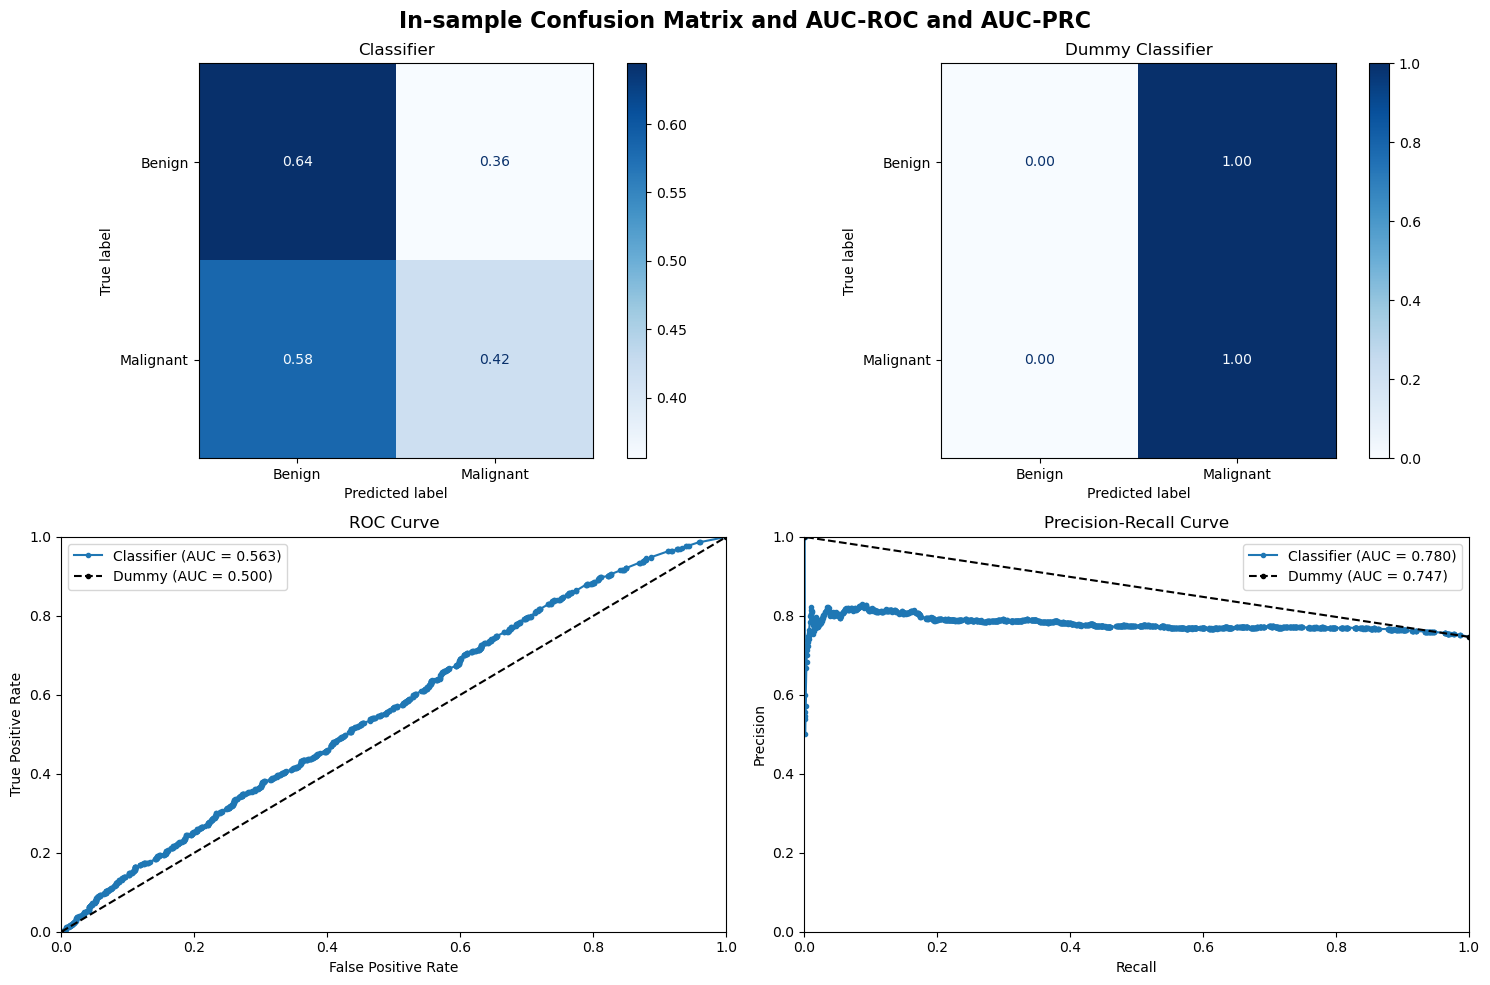

{'y_pred': array([0, 0, 0, ..., 1, 0, 1]),
 'y_pred_score': array([0.17922705, 0.22953222, 0.19632107, ..., 0.79246939, 0.49487179,
        0.62307692]),
 'precision': 0.7757166947723441,
 'recall': 0.41742286751361163,
 'accuracy': 0.4749322493224932,
 'f1': 0.5427728613569321,
 'f2': 0.45990801839632073,
 'confusion_matrix': array([[0.64438503, 0.35561497],
        [0.58257713, 0.41742287]]),
 'prc': (array([0.74661247, 0.7516129 , 0.75172891, ..., 1.        , 1.        ,
         1.        ]),
  array([1.00000000e+00, 9.86690865e-01, 9.86388385e-01, ...,
         6.04960678e-04, 3.02480339e-04, 0.00000000e+00])),
 'roc': (array([0.        , 0.        , 0.        , ..., 0.95989305, 0.96078431,
         1.        ]),
  array([0.00000000e+00, 3.02480339e-04, 6.04960678e-04, ...,
         9.86388385e-01, 9.86690865e-01, 1.00000000e+00]))}

In [22]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['RandomForest'],X_train, y_train, classification_labels, in_sample=True)

Classifier - Precision: 0.99, Recall: 0.98, Accuracy: 0.98, F1 Score: 0.98, F2 Score: 0.98
Dummy Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.86, F2 Score: 0.94


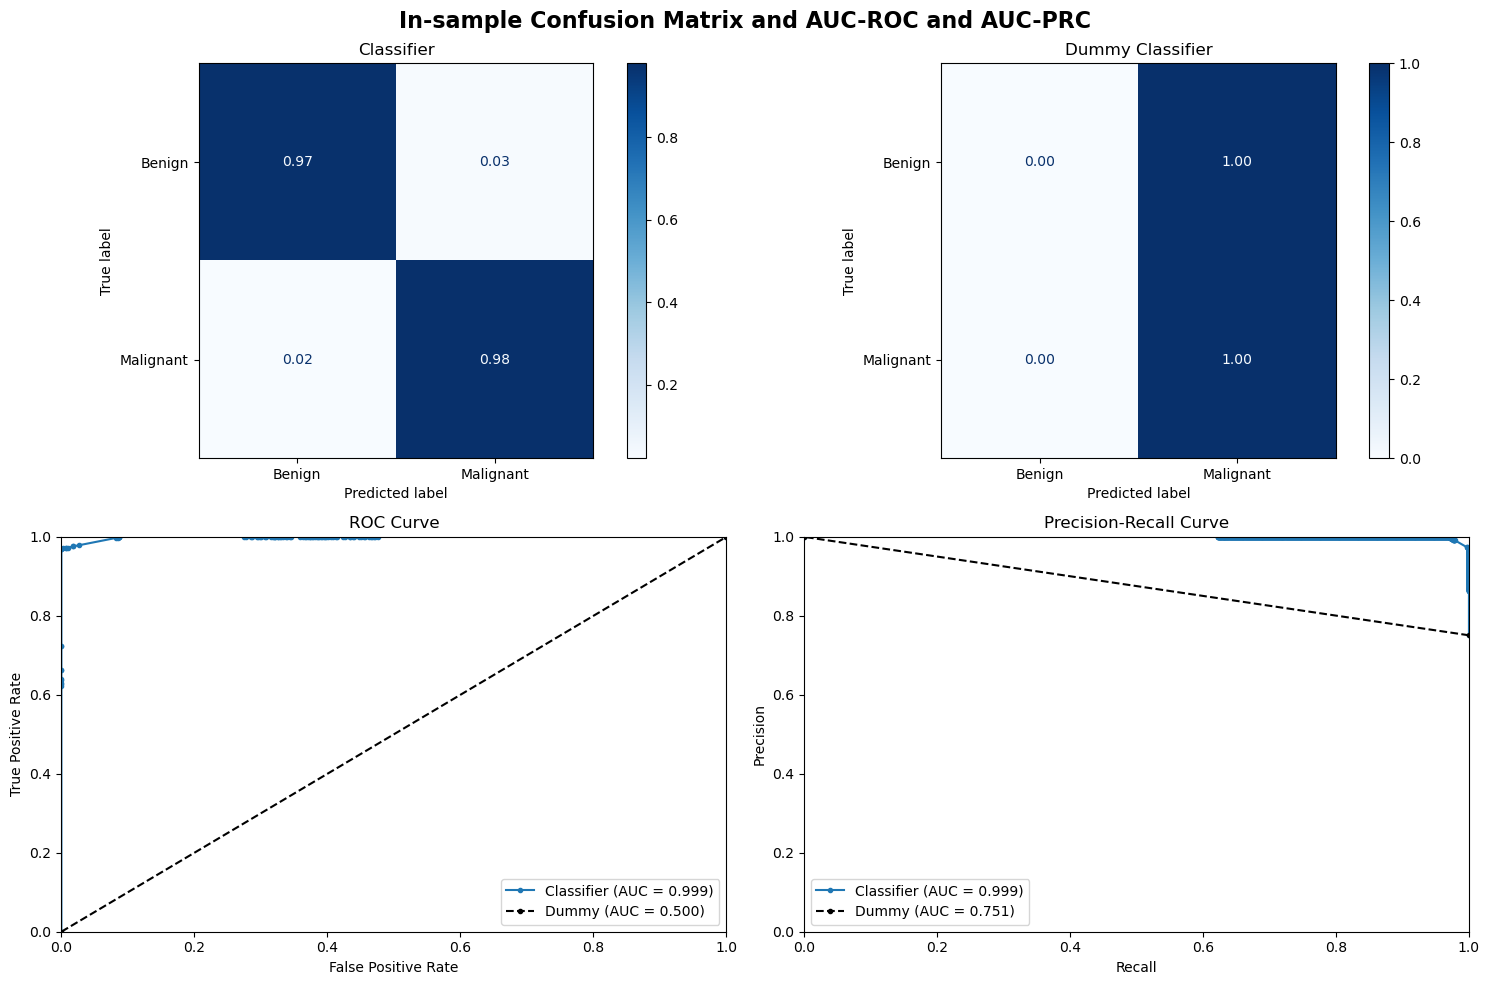

{'y_pred': array([0, 0, 0, ..., 1, 1, 1]),
 'y_pred_score': array([0.        , 0.        , 0.        , ..., 0.99999991, 1.        ,
        0.99999992]),
 'precision': 0.9912571600844137,
 'recall': 0.9785714285714285,
 'accuracy': 0.9774352100089365,
 'f1': 0.9848734461584544,
 'f2': 0.9810825326729128,
 'confusion_matrix': array([[0.97401434, 0.02598566],
        [0.02142857, 0.97857143]]),
 'prc': (array([0.75067024, 0.86353123, 0.86375321, ..., 1.        , 1.        ,
         1.        ]),
  array([1.        , 1.        , 1.        , ..., 0.62261905, 0.62232143,
         0.        ])),
 'roc': (array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00268817, 0.0062724 ,
         0.0062724 , 0.00985663, 0.01792115, 0.01792115, 0.02598566,
         0.08243728, 0.08512545, 0.08512545, 0.08602151, 0.08602151,
         0.08691756, 0.08691756, 0.27508961, 0.276

In [59]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['KNN'],X_train, y_train, classification_labels, in_sample=True)

Classifier - Precision: 0.81, Recall: 1.00, Accuracy: 0.83, F1 Score: 0.90, F2 Score: 0.96
Dummy Classifier - Precision: 0.75, Recall: 1.00, Accuracy: 0.75, F1 Score: 0.86, F2 Score: 0.94


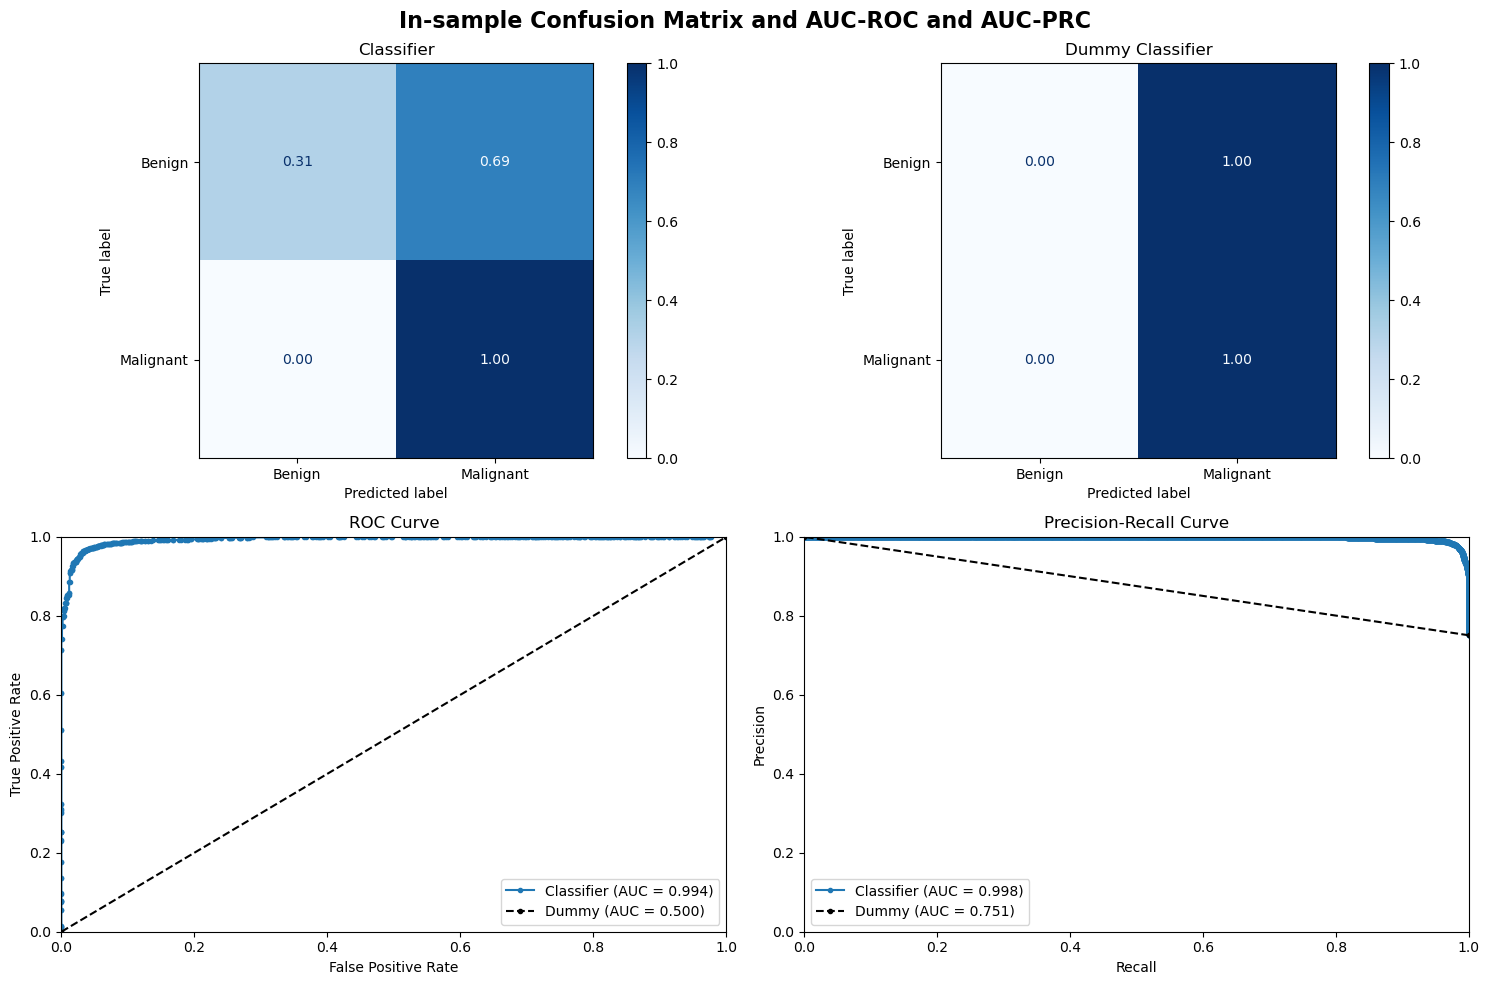

{'y_pred': array([1, 0, 1, ..., 1, 1, 1]),
 'y_pred_score': array([0.52976514, 0.37239291, 0.52599009, ..., 0.79354139, 0.77288869,
        0.81980906]),
 'precision': 0.813953488372093,
 'recall': 1.0,
 'accuracy': 0.8284182305630027,
 'f1': 0.8974358974358975,
 'f2': 0.9562841530054644,
 'confusion_matrix': array([[0.31182796, 0.68817204],
        [0.        , 1.        ]]),
 'prc': (array([0.75067024, 0.75100581, 0.75134168, ..., 1.        , 1.        ,
         1.        ]),
  array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         5.95238095e-04, 2.97619048e-04, 0.00000000e+00])),
 'roc': (array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+0

In [60]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['GradientBoosting'],X_train, y_train, classification_labels, in_sample=True)

# Apply Model to test data

## Out-of-Sample ROC-AUC Comparison

In [24]:
importlib.reload(classifier)
results_test  = classifier.evaluate_models_on_test(trained_models, X_test, y_test)

In [80]:
importlib.reload(showcase_and_graphs)
showcase_and_graphs.compare_model_metrics(results_test, y_test)

           Model  Accuracy  Precision  Recall    F1    F2  AUC-ROC  AUC-PRC
             SGD     0.727      0.737   0.975 0.839 0.916    0.664    0.845
        Logistic     0.726      0.739   0.967 0.838 0.911    0.663    0.844
    RandomForest     0.732      0.736   0.988 0.843 0.924    0.618    0.807
             KNN     0.703      0.734   0.931 0.821 0.884    0.544    0.758
GradientBoosting     0.733      0.733   0.999 0.846 0.931    0.631    0.812


Model  Accuracy  Precision    Recall        F1        F2  \
0               SGD  0.727110   0.736549  0.975430  0.839323  0.916013   
1          Logistic  0.726212   0.738967  0.966830  0.837680  0.910669   
2      RandomForest  0.731598   0.735590  0.987715  0.843209  0.924350   
3               KNN  0.702873   0.733785  0.931204  0.820790  0.883656   
4  GradientBoosting  0.733393   0.733093  0.998771  0.845554  0.931271   

    AUC-ROC   AUC-PRC  
0  0.664382  0.845017  
1  0.662776  0.844414  
2  0.618473  0.806768  
3  0.543516  0.757518  
4  0.630528  0.812492

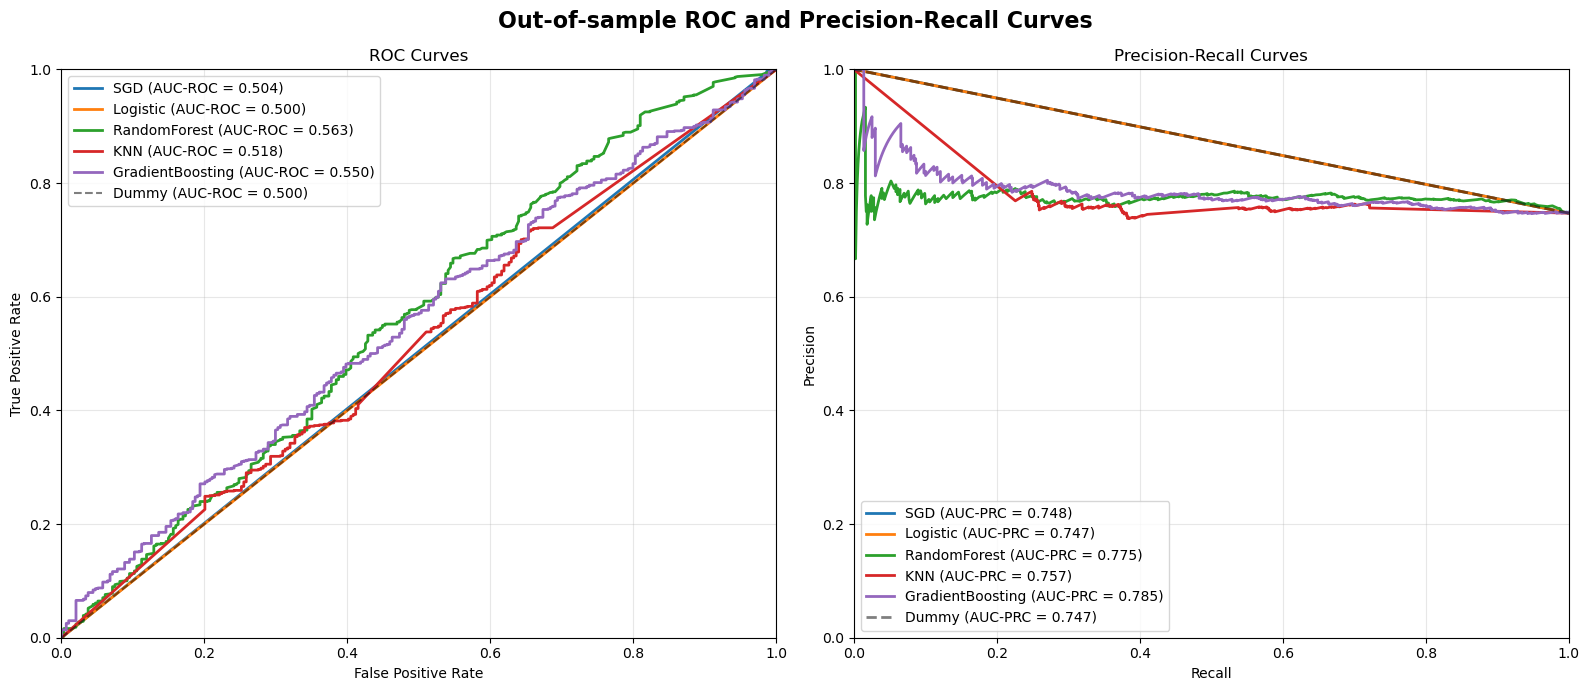

In [25]:
importlib.reload(showcase_and_graphs)
showcase_and_graphs.plot_auc_curves(results_test, y_test, in_sample=False)

## Out-of-Sample Confusion Matrices and AUCs

Classifier - Precision: 0.74, Recall: 0.98, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.92
Dummy Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.93


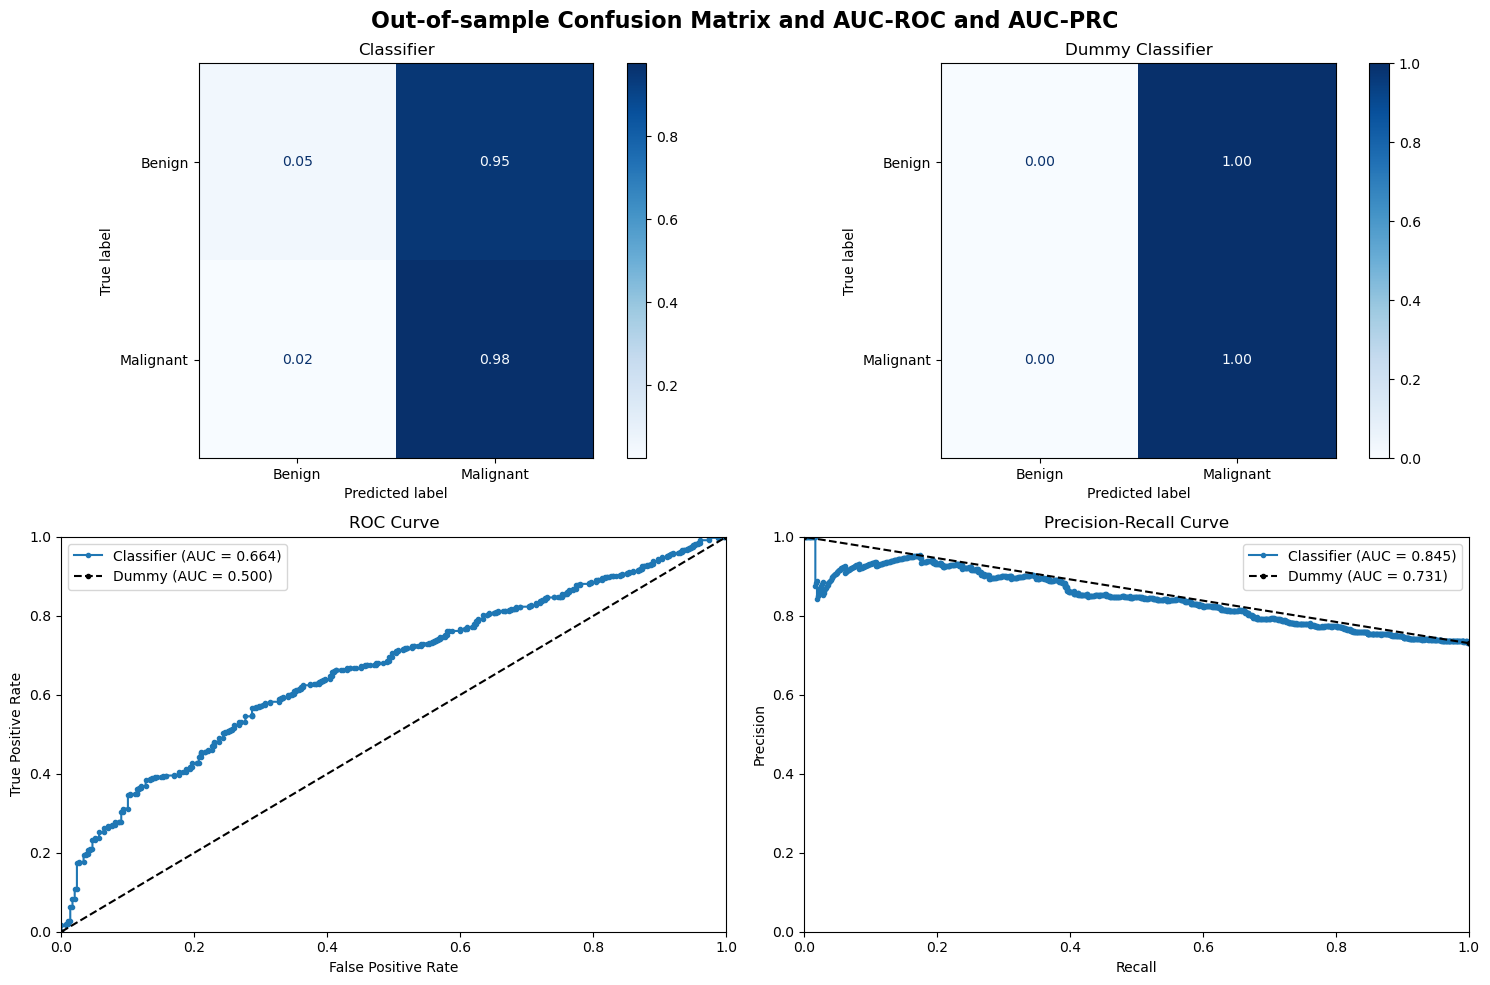

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([0.74160533, 0.71865804, 0.66367571, ..., 0.76452456, 0.73494081,
        0.79035232]),
 'precision': 0.7365491651205937,
 'recall': 0.9754299754299754,
 'accuracy': 0.7271095152603232,
 'f1': 0.8393234672304439,
 'f2': 0.9160129210890632,
 'confusion_matrix': array([[0.05333333, 0.94666667],
        [0.02457002, 0.97542998]]),
 'prc': (array([0.73070018, 0.73135669, 0.73111511, ..., 1.        , 1.        ,
         1.        ]),
  array([1.       , 1.       , 0.9987715, ..., 0.002457 , 0.0012285,
         0.       ])),
 'roc': (array([0.        , 0.        , 0.        , 0.00666667, 0.00666667,
         0.01      , 0.01      , 0.01333333, 0.01333333, 0.01666667,
         0.01666667, 0.02      , 0.02      , 0.02333333, 0.02333333,
         0.02666667, 0.02666667, 0.03333333, 0.03333333, 0.03666667,
         0.03666667, 0.04      , 0.04      , 0.04333333, 0.04333333,
         0.04666667, 0.04666667, 0.05      , 0.05      ,

In [82]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['SGD'],X_test, y_test, classification_labels, in_sample=False)

Classifier - Precision: 0.74, Recall: 0.97, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.91
Dummy Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.93


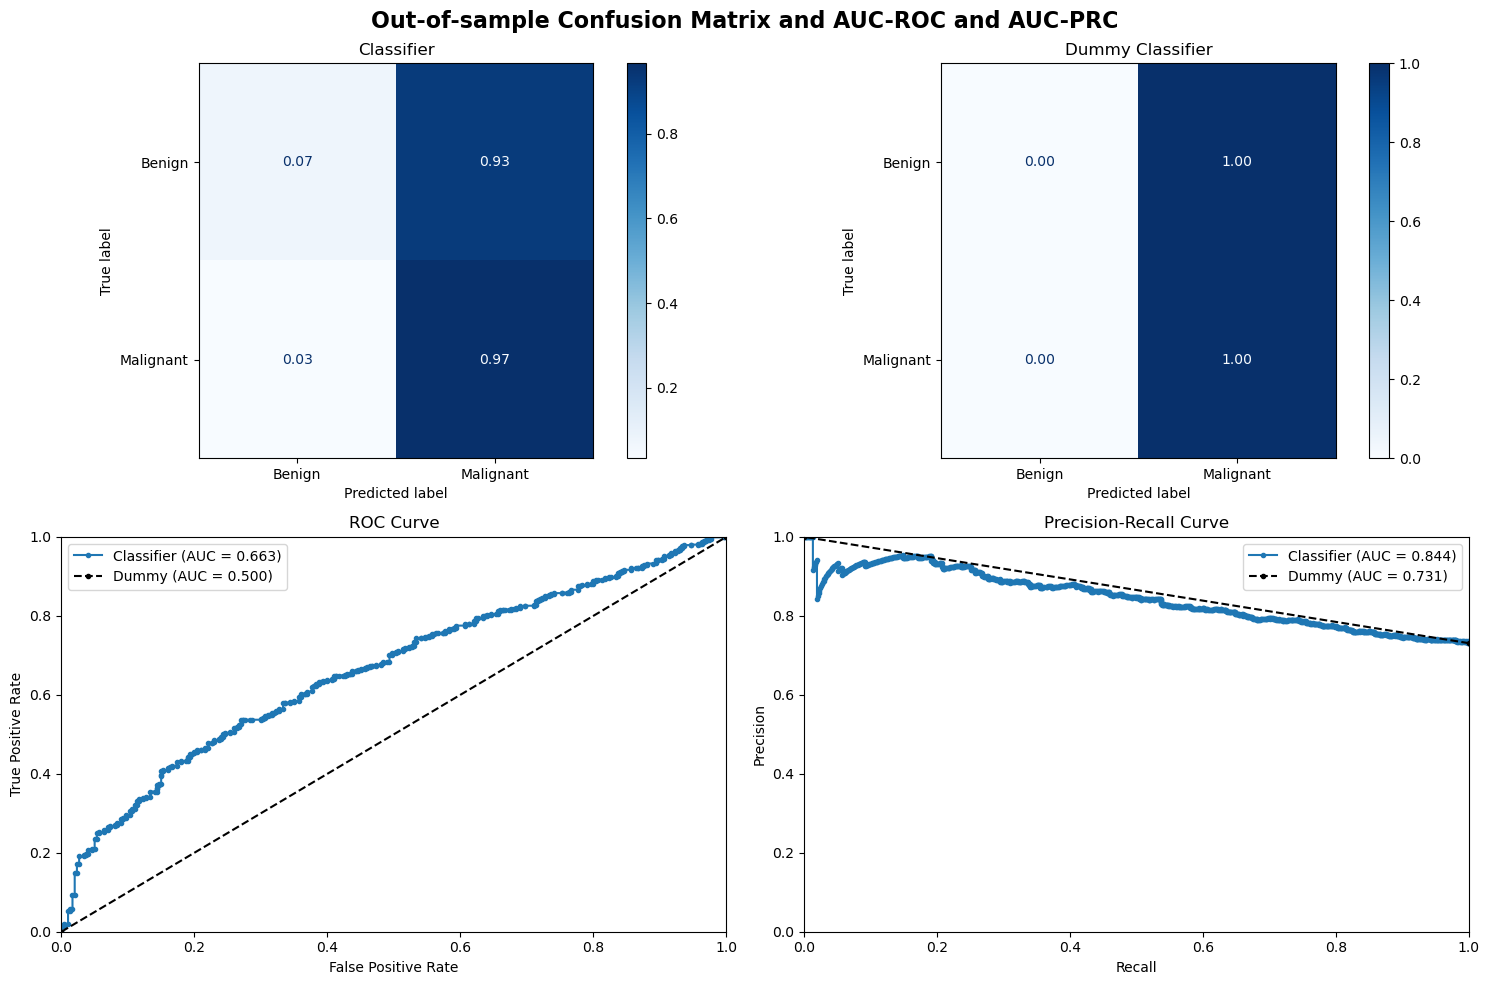

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([0.72495397, 0.69212683, 0.68081189, ..., 0.78869359, 0.72288204,
        0.79682835]),
 'precision': 0.7389671361502348,
 'recall': 0.9668304668304668,
 'accuracy': 0.7262118491921006,
 'f1': 0.8376796168174561,
 'f2': 0.9106688266604952,
 'confusion_matrix': array([[0.07333333, 0.92666667],
        [0.03316953, 0.96683047]]),
 'prc': (array([0.73070018, 0.73135669, 0.73111511, ..., 1.        , 1.        ,
         1.        ]),
  array([1.       , 1.       , 0.9987715, ..., 0.002457 , 0.0012285,
         0.       ])),
 'roc': (array([0.        , 0.        , 0.        , 0.00333333, 0.00333333,
         0.01      , 0.01      , 0.01333333, 0.01333333, 0.01666667,
         0.01666667, 0.02      , 0.02      , 0.02333333, 0.02333333,
         0.02666667, 0.02666667, 0.03333333, 0.03333333, 0.03666667,
         0.03666667, 0.04      , 0.04      , 0.04666667, 0.04666667,
         0.05      , 0.05      , 0.05333333, 0.05333333,

In [83]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['Logistic'],X_test, y_test, classification_labels, in_sample=False)

Classifier - Precision: 0.74, Recall: 0.99, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.92
Dummy Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.93


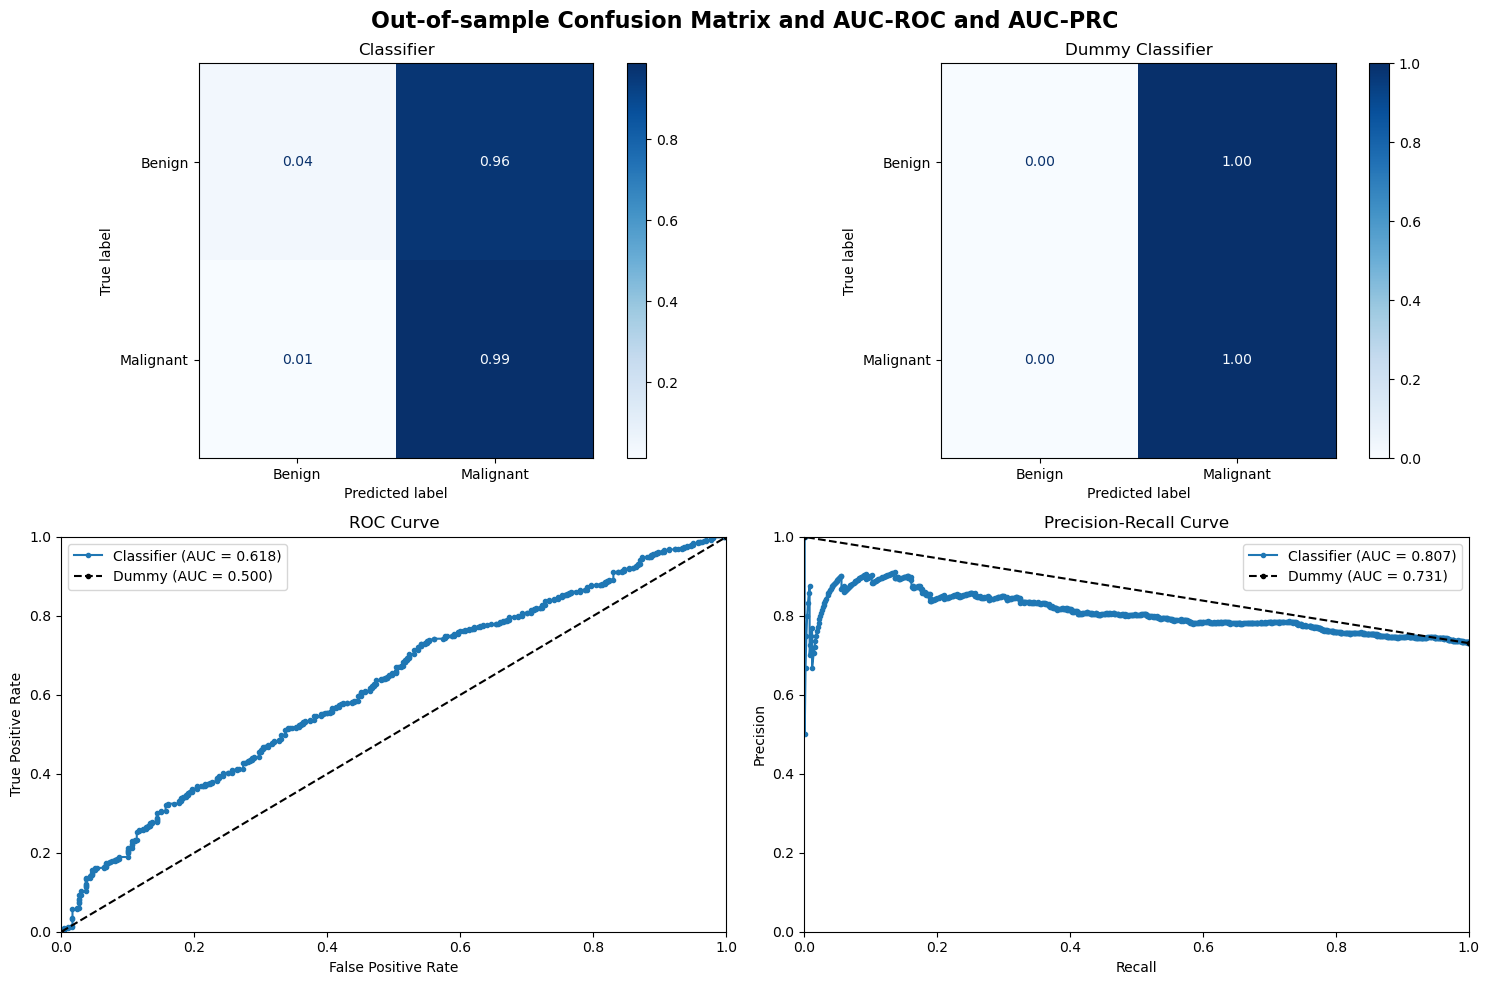

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([0.71916667, 0.8595    , 0.504     , ..., 0.85192857, 0.74083333,
        0.84783333]),
 'precision': 0.7355901189387009,
 'recall': 0.9877149877149877,
 'accuracy': 0.7315978456014363,
 'f1': 0.843209229155742,
 'f2': 0.924350425385146,
 'confusion_matrix': array([[0.03666667, 0.96333333],
        [0.01228501, 0.98771499]]),
 'prc': (array([0.73070018, 0.73135669, 0.73111511, 0.73177318, 0.73243243,
         0.73309288, 0.73375451, 0.73441734, 0.73417722, 0.73393665,
         0.73460145, 0.73436083, 0.73411978, 0.73387829, 0.73363636,
         0.73430391, 0.73497268, 0.73473108, 0.73448905, 0.73515982,
         0.73559012, 0.73626374, 0.736022  , 0.73669725, 0.73645546,
         0.73621324, 0.73756906, 0.73732719, 0.73708487, 0.73684211,
         0.73659889, 0.7372803 , 0.73703704, 0.73679333, 0.73747681,
         0.73816156, 0.73791822, 0.73860465, 0.73836127, 0.73811743,
         0.73787313, 0.73856209, 0.73831776, 0.

In [84]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['RandomForest'],X_test, y_test, classification_labels, in_sample=False)

Classifier - Precision: 0.73, Recall: 0.93, Accuracy: 0.70, F1 Score: 0.82, F2 Score: 0.88
Dummy Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.93


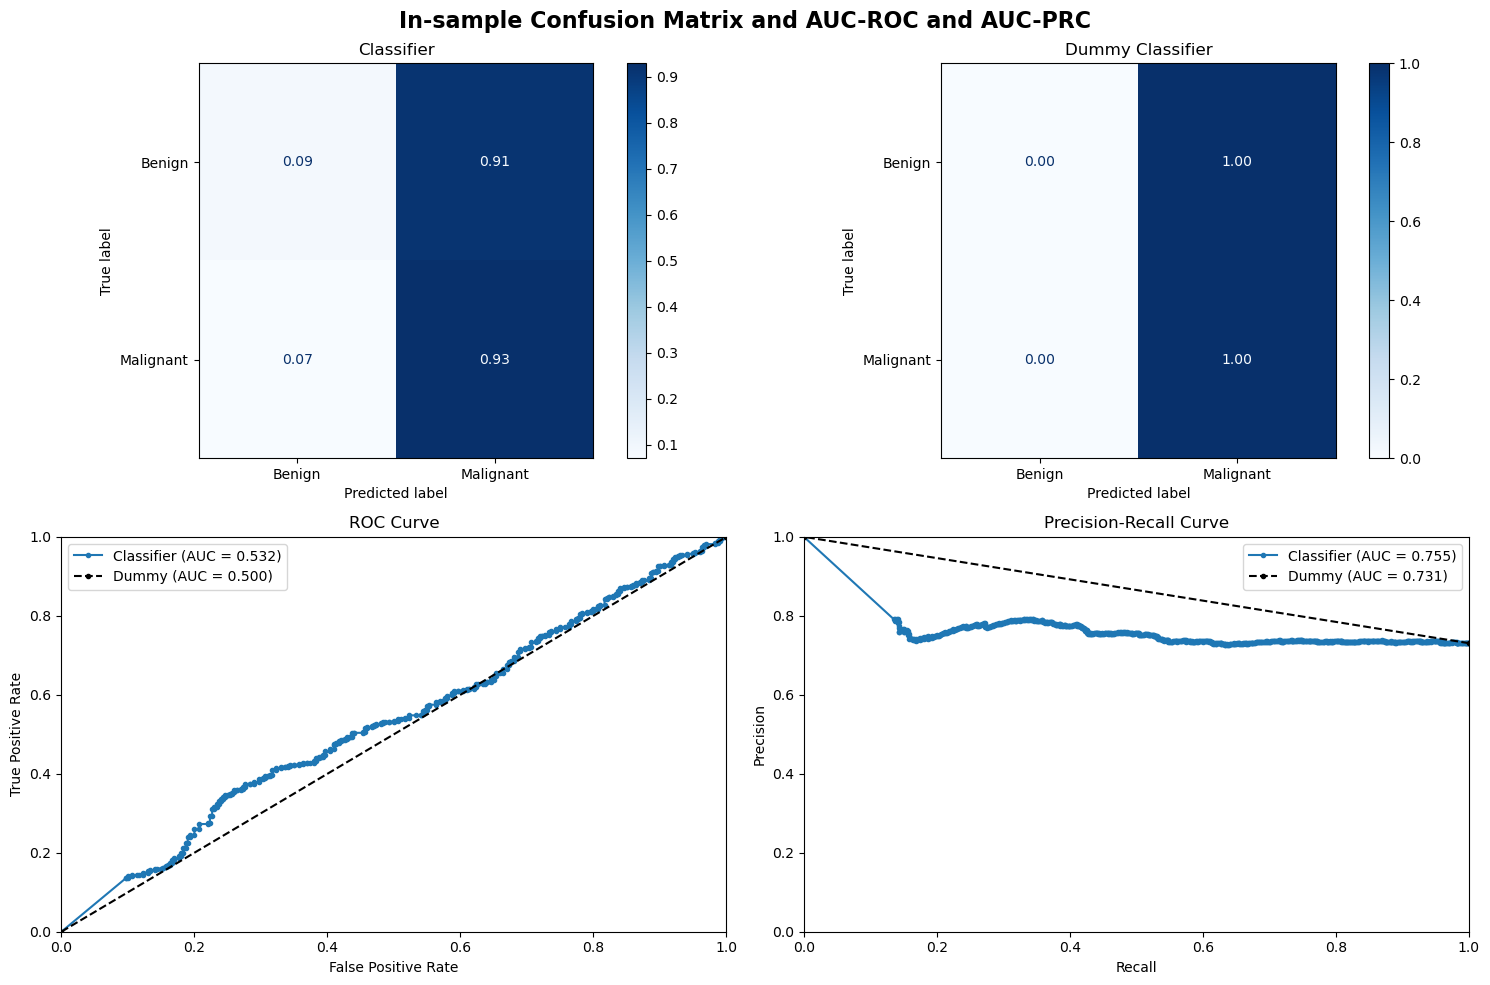

{'y_pred': array([1, 1, 0, ..., 1, 1, 1]),
 'y_pred_score': array([0.89728368, 0.56852809, 0.49130828, ..., 0.70272815, 0.51587024,
        0.70169694]),
 'precision': 0.7339805825242719,
 'recall': 0.9287469287469288,
 'accuracy': 0.7019748653500898,
 'f1': 0.8199566160520607,
 'f2': 0.8819412039197387,
 'confusion_matrix': array([[0.08666667, 0.91333333],
        [0.07125307, 0.92874693]]),
 'prc': (array([0.73070018, 0.73045822, 0.73111511, 0.73177318, 0.73153153,
         0.73128945, 0.73194946, 0.73170732, 0.73146474, 0.73122172,
         0.73097826, 0.73073436, 0.7311535 , 0.73090909, 0.73066424,
         0.73041894, 0.7301732 , 0.73083942, 0.73059361, 0.73034735,
         0.73101555, 0.73168498, 0.73235564, 0.73302752, 0.73278237,
         0.73321067, 0.73296501, 0.73271889, 0.73247232, 0.7322253 ,
         0.73290203, 0.73265495, 0.73240741, 0.73215941, 0.73191095,
         0.73166202, 0.73141264, 0.73116279, 0.73091248, 0.73159366,
         0.73134328, 0.73109244, 0.7317757 , 

In [ ]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['KNN'],X_test, y_test, classification_labels, in_sample=False)

Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.85, F2 Score: 0.93
Dummy Classifier - Precision: 0.73, Recall: 1.00, Accuracy: 0.73, F1 Score: 0.84, F2 Score: 0.93


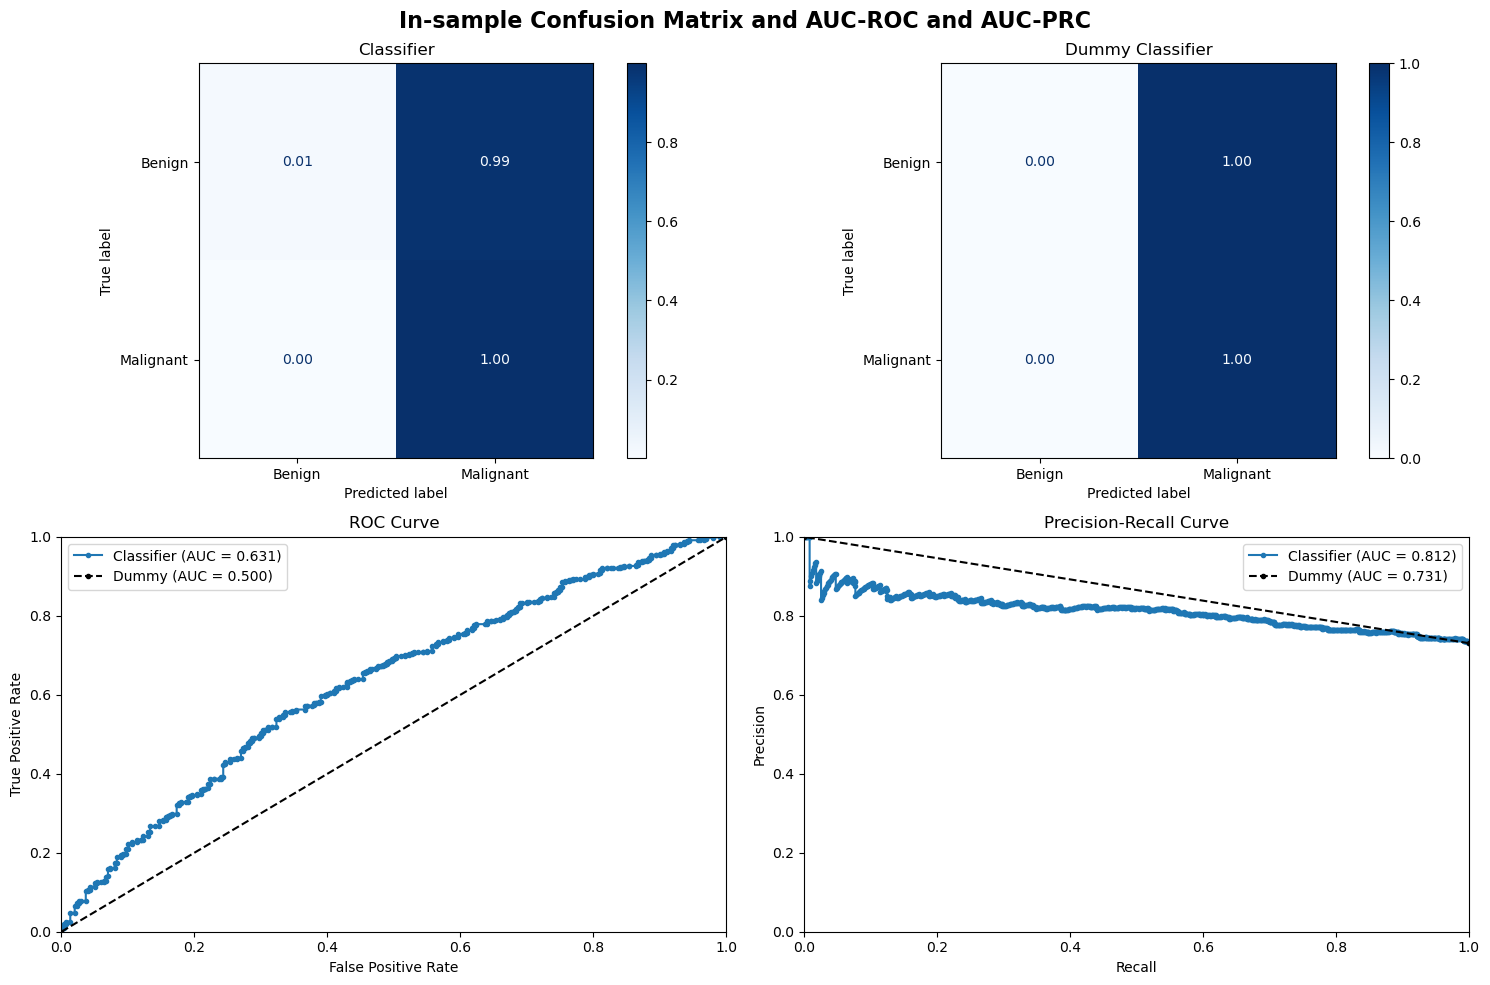

{'y_pred': array([1, 1, 1, ..., 1, 1, 1]),
 'y_pred_score': array([0.78296595, 0.82354194, 0.66000558, ..., 0.76415415, 0.76130248,
        0.83464958]),
 'precision': 0.7330928764652841,
 'recall': 0.9987714987714987,
 'accuracy': 0.7333931777378815,
 'f1': 0.8455538221528861,
 'f2': 0.9312714776632303,
 'confusion_matrix': array([[0.01333333, 0.98666667],
        [0.0012285 , 0.9987715 ]]),
 'prc': (array([0.73070018, 0.73135669, 0.73201439, ..., 1.        , 1.        ,
         1.        ]),
  array([1.       , 1.       , 1.       , ..., 0.002457 , 0.0012285,
         0.       ])),
 'roc': (array([0.        , 0.        , 0.        , 0.00333333, 0.00333333,
         0.00666667, 0.00666667, 0.01333333, 0.01333333, 0.02      ,
         0.02      , 0.02333333, 0.02333333, 0.02666667, 0.02666667,
         0.03      , 0.03666667, 0.03666667, 0.04      , 0.04      ,
         0.04333333, 0.04333333, 0.05      , 0.05      , 0.05333333,
         0.05333333, 0.06      , 0.06333333, 0.06333333,

In [ ]:
# Plot the confusion matrix, AUC-ROC and AUC-PRC for a specific classifier vs Dummy Classifier ()
importlib.reload(showcase_and_graphs)
showcase_and_graphs.evaluate_and_plot_classifier(trained_models['GradientBoosting'],X_test, y_test, classification_labels, in_sample=False)